# Suicide Rates Overview 1985 to 2016

Verisetimiz ülke,cinsiyet,yaş aralığı,jenerasyon,yıla göre intihar sayılarını vermektedir. Ayrıca ülkelerin populasyon, yıllık milli geliri, kişi başı geliri ve insani gelişmişlik bilgilerinden oluşmaktadır.

In [1158]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import normalize
import pycountry_convert as pc
import warnings
warnings.filterwarnings('ignore')


In [1159]:
data = pd.read_csv('master.csv')

In [1160]:
df=data.copy()

In [1161]:
df.head(5)

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


Verilerimiz kaç kolon ve satırdan oluşuyor. Bunların tipi nedir? Aşağıda ona bakıyoruz.

In [1162]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             27820 non-null  object 
 1   year                27820 non-null  int64  
 2   sex                 27820 non-null  object 
 3   age                 27820 non-null  object 
 4   suicides_no         27820 non-null  int64  
 5   population          27820 non-null  int64  
 6   suicides/100k pop   27820 non-null  float64
 7   country-year        27820 non-null  object 
 8   HDI for year        8364 non-null   float64
 9    gdp_for_year ($)   27820 non-null  object 
 10  gdp_per_capita ($)  27820 non-null  int64  
 11  generation          27820 non-null  object 
dtypes: float64(2), int64(4), object(6)
memory usage: 2.5+ MB


Veriler nesne ve sayısal değerlerden oluşmaktadır.
gdp_for_year değişkeninin object olduğunu görüyorum. Ancak dolar olmasından aslında nümerik olmasını bekliyordum.
Bunu dönüşüm yapmam gerekecek.

Ayrıca değişkenlerin adlarında boşluk gördüm. Ondan kurtulmam gerekli.
Başında sonunda tam olarak görmek için aşağıda isimlerine tekrar bakıyorum.

In [1163]:
print(df.columns)

Index(['country', 'year', 'sex', 'age', 'suicides_no', 'population',
       'suicides/100k pop', 'country-year', 'HDI for year',
       ' gdp_for_year ($) ', 'gdp_per_capita ($)', 'generation'],
      dtype='object')


Aşağıda gdp_for_year ($) değişkeninin ismini değiştiriyorum.

In [1164]:
3#df[" gdp_for_year ($) "] = df["gdp_for_year ($)"]
df.rename(columns = {' gdp_for_year ($) ':'gdp_for_year_usd'},inplace = True)

In [1165]:
#Yukarıda ayrıca object olarak bakınca gözüme gdp_for_year_usd kolonu çarpıyor bunu nümerik yapalım.
#Nümerik yaparken , den kurtulmamız gerekli.
#df["gdp_for_year"] = df["gdp_for_year"].str.replace(",","").astype(np.int64)
df["gdp_for_year_usd"] = df["gdp_for_year_usd"].str.replace(",","")


In [1166]:
df["gdp_for_year_usd"] = pd.to_numeric(df["gdp_for_year_usd"], downcast="float")
df["gdp_for_year_usd"]

0        2.156625e+09
1        2.156625e+09
2        2.156625e+09
3        2.156625e+09
4        2.156625e+09
             ...     
27815    6.306708e+10
27816    6.306708e+10
27817    6.306708e+10
27818    6.306708e+10
27819    6.306708e+10
Name: gdp_for_year_usd, Length: 27820, dtype: float32

In [1167]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             27820 non-null  object 
 1   year                27820 non-null  int64  
 2   sex                 27820 non-null  object 
 3   age                 27820 non-null  object 
 4   suicides_no         27820 non-null  int64  
 5   population          27820 non-null  int64  
 6   suicides/100k pop   27820 non-null  float64
 7   country-year        27820 non-null  object 
 8   HDI for year        8364 non-null   float64
 9   gdp_for_year_usd    27820 non-null  float32
 10  gdp_per_capita ($)  27820 non-null  int64  
 11  generation          27820 non-null  object 
dtypes: float32(1), float64(2), int64(4), object(5)
memory usage: 2.4+ MB


In [1168]:
df.nunique()
#Aşağıda 101 ülkenin verisini içerdiğini görüyoruz.

country                 101
year                     32
sex                       2
age                       6
suicides_no            2084
population            25564
suicides/100k pop      5298
country-year           2321
HDI for year            305
gdp_for_year_usd       2321
gdp_per_capita ($)     2233
generation                6
dtype: int64

In [1169]:
df.sex.value_counts()

female    13910
male      13910
Name: sex, dtype: int64

In [1170]:
#Hangi ülkeler var bakalım.
df["country"].unique()

array(['Albania', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Barbados', 'Belarus', 'Belgium', 'Belize',
       'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Cabo Verde',
       'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Croatia', 'Cuba',
       'Cyprus', 'Czech Republic', 'Denmark', 'Dominica', 'Ecuador',
       'El Salvador', 'Estonia', 'Fiji', 'Finland', 'France', 'Georgia',
       'Germany', 'Greece', 'Grenada', 'Guatemala', 'Guyana', 'Hungary',
       'Iceland', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan',
       'Kazakhstan', 'Kiribati', 'Kuwait', 'Kyrgyzstan', 'Latvia',
       'Lithuania', 'Luxembourg', 'Macau', 'Maldives', 'Malta',
       'Mauritius', 'Mexico', 'Mongolia', 'Montenegro', 'Netherlands',
       'New Zealand', 'Nicaragua', 'Norway', 'Oman', 'Panama', 'Paraguay',
       'Philippines', 'Poland', 'Portugal', 'Puerto Rico', 'Qatar',
       'Republic of Korea', 'Romania', '

In [1171]:
#Veriler kendini tekrarlıyor mu , nasıl geliyor anlamak için bir yıl, bir ülke için veriler nasıl gözüküyor.
df[(df["year"]==2009) & (df["country"]=="Turkey")]

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year_usd,gdp_per_capita ($),generation
25636,Turkey,2009,male,75+ years,33,806623,4.09,Turkey2009,NaN,6.446399e+11,9773,Silent
25637,Turkey,2009,male,55-74 years,130,3897113,3.34,Turkey2009,NaN,6.446399e+11,9773,Silent
25638,Turkey,2009,male,35-54 years,287,9160329,3.13,Turkey2009,NaN,6.446399e+11,9773,Boomers
25639,Turkey,2009,male,25-34 years,189,6272520,3.01,Turkey2009,NaN,6.446399e+11,9773,Generation X
25640,Turkey,2009,male,15-24 years,139,6380792,2.18,Turkey2009,NaN,6.446399e+11,9773,Millenials
25641,Turkey,2009,female,75+ years,17,1170072,1.45,Turkey2009,NaN,6.446399e+11,9773,Silent
25642,Turkey,2009,female,15-24 years,74,6097408,1.21,Turkey2009,NaN,6.446399e+11,9773,Millenials
25643,Turkey,2009,female,55-74 years,38,4301203,0.88,Turkey2009,NaN,6.446399e+11,9773,Silent
25644,Turkey,2009,female,25-34 years,44,6101898,0.72,Turkey2009,NaN,6.446399e+11,9773,Generation X
25645,Turkey,2009,female,35-54 years,58,9027289,0.64,Turkey2009,NaN,6.446399e+11,9773,Boomers


In [1172]:
#Ayrıca şu an için country-year ve gdp_for_year_usd değişkenlerini kullanmayacağım onları verisetimden çıkarıyorum.
df = df.drop("country-year",axis=1,errors="ignore")
#df = df.drop("population",axis=1,errors="ignore")
df = df.drop("gdp_for_year_usd",axis=1,errors="ignore")
df.head(3)

,country,year,sex,age,suicides_no,population,suicides/100k pop,HDI for year,gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,NaN,796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,NaN,796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,NaN,796,Generation X


In [1173]:
#Aşağıda nümerik değerler için olan değişkenlerin ort,std sapma vb gibi istatistiksel değerlerine bakabiliriz.
df.describe()

,year,suicides_no,population,suicides/100k pop,HDI for year,gdp_per_capita ($)
count,27820.000000,27820.000000,2.782000e+04,27820.000000,8364.000000,27820.000000
mean,2001.258375,242.574407,1.844794e+06,12.816097,0.776601,16866.464414
std,8.469055,902.047917,3.911779e+06,18.961511,0.093367,18887.576472
min,1985.000000,0.000000,2.780000e+02,0.000000,0.483000,251.000000
25%,1995.000000,3.000000,9.749850e+04,0.920000,0.713000,3447.000000
50%,2002.000000,25.000000,4.301500e+05,5.990000,0.779000,9372.000000
75%,2008.000000,131.000000,1.486143e+06,16.620000,0.855000,24874.000000
max,2016.000000,22338.000000,4.380521e+07,224.970000,0.944000,126352.000000


In [1174]:
#Kategorik değişkenlerinde yukarıdaki gibi analizini yapabilmek için describe fonksiyonunun include all methodunu kullanırız. Yukarıda nümeriklere baktığımız için ben aşağıda sadece object olanlara bakacağım.
df.describe(include=[object])

,country,sex,age,generation
count,27820,27820,27820,27820
unique,101,2,6,6
top,Austria,female,35-54 years,Generation X
freq,382,13910,4642,6408


In [1175]:
#Şimdi eksik değerlere bakalım.
df.isnull().sum()

country                   0
year                      0
sex                       0
age                       0
suicides_no               0
population                0
suicides/100k pop         0
HDI for year          19456
gdp_per_capita ($)        0
generation                0
dtype: int64

Yukarıda eksik değerlerin sadece bir kolonda olduğunu görüyorum. Ve bununda veri setinde yüzde kaçına denk geldiğine bakalım.

In [1176]:
df.isnull().sum()/len(df)*100

country                0.000000
year                   0.000000
sex                    0.000000
age                    0.000000
suicides_no            0.000000
population             0.000000
suicides/100k pop      0.000000
HDI for year          69.935298
gdp_per_capita ($)     0.000000
generation             0.000000
dtype: float64

<AxesSubplot:>

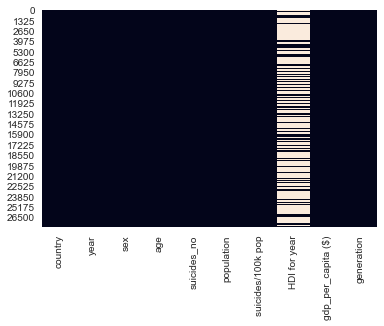

In [1177]:
#eksik verileri bir de grafikle görelim. Açık renk ile gelenler aşağıda eksik olan satırlar.
sns.heatmap(df.isnull(), cbar=False)

Eksik veriler %70 ne denk geldiği için doldurmak yerine bu kolonu verisetimden kaldırıyorum.

In [1224]:
#Örneğin doldurmak gerekseydi ülkelerin ortalamalarıyla ülke bazında aşağıdaki şekilde doldurabilirdik.
#df["HDI for year"]=df.groupby(["country"])["HDI for year"].apply(lambda x: x.fillna(x.mean()))

df = df.drop("HDI for year",axis=1,errors="ignore")
df.head(5)

,country,year,sex,age,suicides_no,population,suicides/100k pop,gdp_per_capita ($),generation,Continent
0,Albania,1987,male,15-24 years,21,312900,6.71,796,Generation X,Europe
1,Albania,1987,male,35-54 years,16,308000,5.19,796,Silent,Europe
2,Albania,1987,female,15-24 years,14,289700,4.83,796,Generation X,Europe
3,Albania,1987,male,75+ years,1,21800,4.59,796,G.I. Generation,Europe
4,Albania,1987,male,25-34 years,9,274300,3.28,796,Boomers,Europe


Kıtalara göre analiz yapabilmek için ülkelerden yola çıkarak kıtaları getirmemiz gerekir.

In [1179]:
def country_to_continent(country_name):
    country_code = pc.country_name_to_country_alpha2(country_name)
    continent_code = pc.country_alpha2_to_continent_code(country_code)
    continent_name = pc.convert_continent_code_to_continent_name(continent_code)
    return continent_name

In [1180]:
def find_invalid(df3):
    #Year just chosen as the variable to count, could use any of the columns here
    grouped = df3.groupby("country")["population"].sum() / 35
    count_missing = df3.groupby("country")["year"].count()
    
    grouped_small = grouped[grouped < 150000].index
    grouped_missing = count_missing[count_missing < 150]
    
    delete_list = grouped_small.append(grouped_missing.index)
    
    return delete_list

In [1181]:
df["country"] = df["country"].replace({"Republic of Korea":"Korea, Republic of"})
df["country"] = df["country"].replace({"Saint Vincent and Grenadines":"Saint Vincent and the Grenadines"})

#Her ülke için kıtasını çeviriyoruz.
df["Continent"] = df.apply(lambda x: country_to_continent(x["country"]), axis = 1)

list_of_invalid = find_invalid(df)
df_continent = df[~df["country"].isin(list_of_invalid)]

In [1253]:
df.head(3)

,country,year,sex,age,suicides_no,population,suicides/100k pop,gdp_per_capita ($),generation,Continent
0,Albania,1987,male,15-24 years,21,312900,6.71,796,Generation X,Europe
1,Albania,1987,male,35-54 years,16,308000,5.19,796,Silent,Europe
2,Albania,1987,female,15-24 years,14,289700,4.83,796,Generation X,Europe


[]

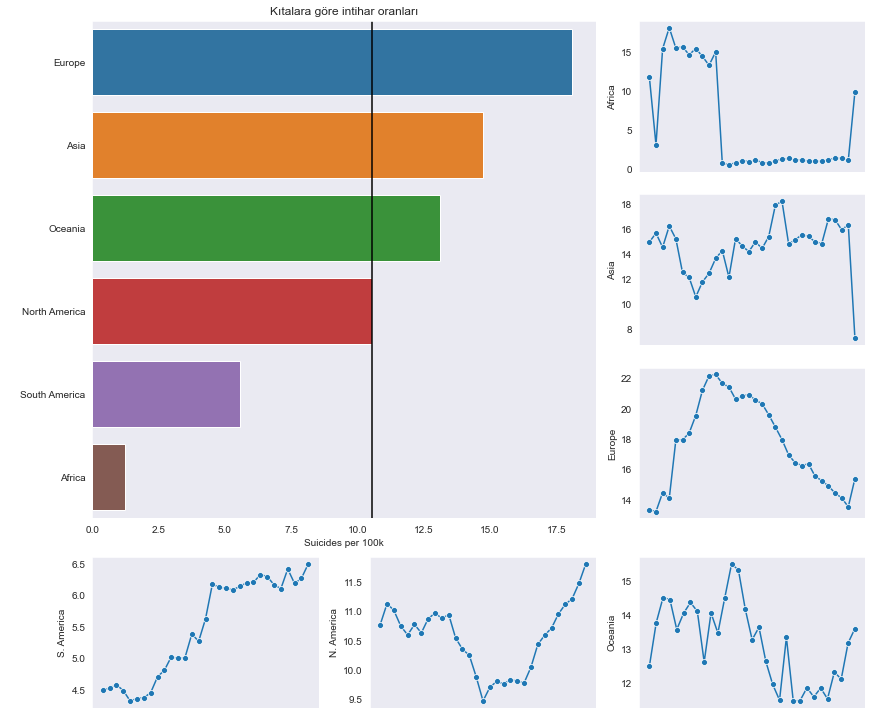

In [1226]:
cont_pop = df_continent.groupby("Continent")["population"].sum()
cont_raw = df_continent.groupby("Continent")["suicides_no"].sum()
cont_rate = ((cont_raw / cont_pop) * 100000).to_frame()
cont_rate = cont_rate.rename(columns = {0: "Average_Rate"})
cont_rate = cont_rate.sort_values(by = "Average_Rate", ascending = False)

cont_year_pop = df_continent.groupby(["Continent", "year"])["population"].sum()
cont_year_raw = df_continent.groupby(["Continent", "year"])["suicides_no"].sum()
cont_year_rate = ((cont_year_raw / cont_year_pop) * 100000).to_frame().reset_index()
cont_year_rate = cont_year_rate.rename(columns = {0: "Average_Rate"})

average = cont_rate["Average_Rate"].mean()

sns.set_style("dark")
fig = plt.figure(constrained_layout=True, figsize = (12,10))
gs = fig.add_gridspec(4, 3)

ax1 = fig.add_subplot(gs[:3, :2])
ax1.set_title("Kıtalara göre intihar oranları")

sns.barplot(ax = ax1, data = cont_rate, y = cont_rate.index, x = cont_rate["Average_Rate"], dodge = False)
ax1.set_ylabel(" ")
ax1.set_xlabel("Suicides per 100k")
ax1.axvline(x = average, c = "black")

ax2 = fig.add_subplot(gs[0, -1])
ax2.set_ylabel('Africa')
ax2.set_xlabel(" ")
sns.lineplot(ax = ax2, data = cont_year_rate.loc[cont_year_rate.Continent == "Africa"], y = "Average_Rate", x = "year", marker = "o")
ax2.get_xaxis().set_ticks([])

ax3 = fig.add_subplot(gs[1, -1])
ax3.set_ylabel('Asia')
ax3.set_xlabel(" ")
sns.lineplot(ax = ax3, data = cont_year_rate.loc[cont_year_rate.Continent == "Asia"], y = "Average_Rate", x = "year", marker = "o")
ax3.get_xaxis().set_ticks([])

ax4 = fig.add_subplot(gs[2, -1])
ax4.set_ylabel('Europe')
ax4.set_xlabel(" ")
sns.lineplot(ax = ax4, data = cont_year_rate.loc[cont_year_rate.Continent == "Europe"], y = "Average_Rate", x = "year", marker = "o")
ax4.get_xaxis().set_ticks([])

ax5 = fig.add_subplot(gs[3, -1])
ax5.set_ylabel("Oceania")
ax5.set_xlabel(" ")
sns.lineplot(ax = ax5, data = cont_year_rate.loc[cont_year_rate.Continent == "Oceania"], y = "Average_Rate", x = "year", marker = "o")
ax5.get_xaxis().set_ticks([])

ax6 = fig.add_subplot(gs[-1, -2])
ax6.set_ylabel('N. America')
ax6.set_xlabel(" ")
sns.lineplot(ax = ax6, data = cont_year_rate.loc[cont_year_rate.Continent == "North America"], y = "Average_Rate", x = "year", marker = "o")
ax6.get_xaxis().set_ticks([])

ax7 = fig.add_subplot(gs[-1, -3])
ax7.set_ylabel('S. America')
ax7.set_xlabel(" ")
sns.lineplot(ax = ax7, data = cont_year_rate.loc[cont_year_rate.Continent == "South America"], y = "Average_Rate", x = "year", marker = "o")
ax7.get_xaxis().set_ticks([])

Kuzey Amerika, dünya ortalamasında. 
Afrika'nın oranına bakmak belki mantıklı olmaz. Çünkü aşağıda baktığımızda sadece 4 ülke olduğu görülüyor.
Güney Amerika, Kuzey Amerika ve Okyanusya'da intiharlar yükselme eğiliminde gözüküyor.

In [1234]:
africa=df[df["Continent"]=="Africa"]
africa["country"].unique()

array(['Cabo Verde', 'Mauritius', 'Seychelles', 'South Africa'],
      dtype=object)

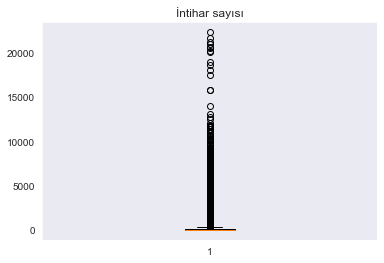

In [1183]:
plt.boxplot(df["suicides_no"])
plt.title("İntihar sayısı")
plt.show()

Burada aykırı değerlere baktım ancak anlamlı şeyler elde edemedim. Çok fazla aykırı değer varmış gibi gözüküyor. Ancak populasyonuna göre o ülkede fazla olabilir. Bu yaklaşım yanlış olur. 
Yıllar ya da ülkeler hatta yaş grupları bazında gruplayarak aşağıdaki bakacağım. Sonuç olarak bu verisetinde aykırı değerler olmadığını düşünüyorum.

Aşağıda dünya genelinde yaşlara göre intihar oranının box plot ile dağılımına bakıyorum. Çok aykırı değer varmış gibi gözükse de Türkiye için baktığımda ortadan kalkıyor. Ülkeler bazında gruplandığında aykırı değerlerin olmadığını düşünüyorum.

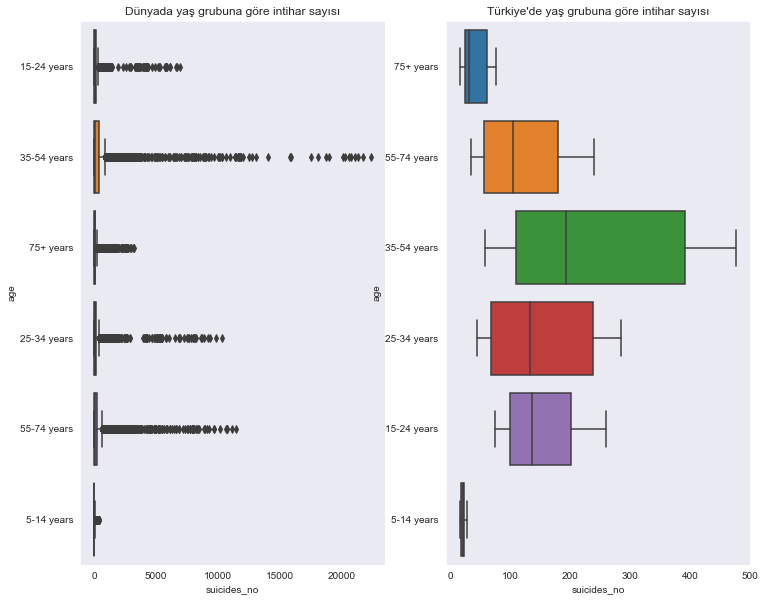

In [1184]:
plt.figure(figsize=(12,10))
plt.subplot(1,2,1)
sns.boxplot(y="age", x="suicides_no", data=df)
plt.title("Dünyada yaş grubuna göre intihar sayısı")

plt.subplot(1,2,2)
sns.boxplot(y="age", x="suicides_no", data=df[df["country"]=='Turkey'])
plt.title("Türkiye'de yaş grubuna göre intihar sayısı")
plt.show()

In [1185]:
#Verileri normalleştirelim.(0-1 arasına ölçeklendirelim.) Normalleştirmeyi aşağıda yaptım ancak kapadım. Bu verisetimde ihtiyacım olmadığını düşünüyorum.

#df["norm_suicides_no"] = normalize(np.array(df["suicides_no"]).reshape(1,-1)).reshape(-1,1)
#df["norm_suicides/100k pop"] = normalize(np.array(df["suicides/100k pop"]).reshape(1,-1)).reshape(-1,1)
#df["norm_gdp_per_capita ($)"] = normalize(np.array(df["gdp_per_capita ($)"]).reshape(1,-1)).reshape(-1,1)
#normal_ozellikler=["suicides_no","norm_suicides_no","suicides/100k pop","norm_suicides/100k pop",
#                    "gdp_per_capita ($)","norm_gdp_per_capita ($)"]

In [1186]:
#Analizlerimde dünya geneline bakarken ayrıca Türkiye'ye de bakacağım. 
df_turkey=df.copy()

In [1187]:
df_turkey= df[df["country"]=='Turkey']
df_turkey

,country,year,sex,age,suicides_no,population,suicides/100k pop,gdp_per_capita ($),generation,Continent
25636,Turkey,2009,male,75+ years,33,806623,4.09,9773,Silent,Asia
25637,Turkey,2009,male,55-74 years,130,3897113,3.34,9773,Silent,Asia
25638,Turkey,2009,male,35-54 years,287,9160329,3.13,9773,Boomers,Asia
25639,Turkey,2009,male,25-34 years,189,6272520,3.01,9773,Generation X,Asia
25640,Turkey,2009,male,15-24 years,139,6380792,2.18,9773,Millenials,Asia
...,...,...,...,...,...,...,...,...,...,...
25715,Turkey,2015,female,25-34 years,72,6288287,1.14,11961,Millenials,Asia
25716,Turkey,2015,female,35-54 years,109,10293526,1.06,11961,Generation X,Asia
25717,Turkey,2015,female,55-74 years,42,5456986,0.77,11961,Boomers,Asia
25718,Turkey,2015,female,5-14 years,18,6100840,0.30,11961,Generation Z,Asia


In [1188]:
print('Toplam intihar sayısı dünya genelinde:', df.suicides_no.sum())

Toplam intihar sayısı dünya genelinde: 6748420


In [1189]:
print("Toplam intihar sayısı Türkiye'de 2009 ve 2015 arası:", df_turkey.suicides_no.sum())

Toplam intihar sayısı Türkiye'de 2009 ve 2015 arası: 10131


In [1190]:
#yaş kolonunda sort values ile sıraladığımda bile 5-14 ortalarda kalıyordu. 0 olmadığından sıralamıyordu.
df["age"] = df["age"].str.replace("5-14 years","05-14 years")

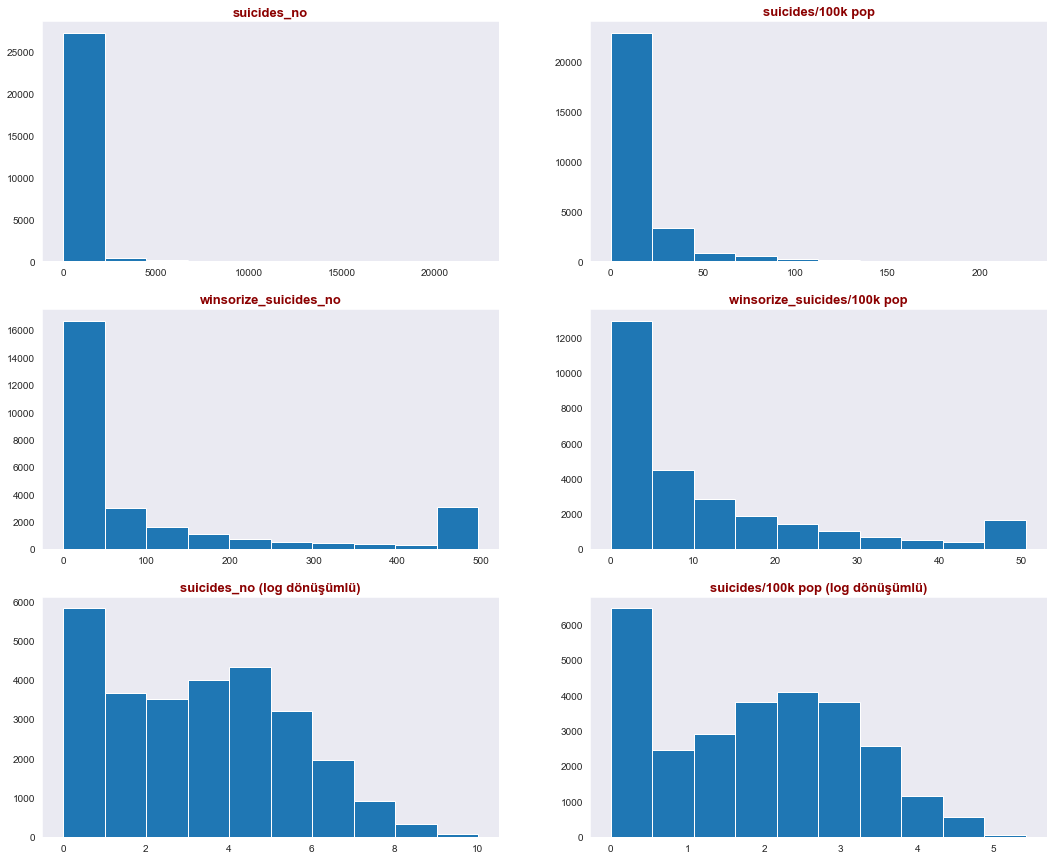

In [1191]:
#Sürekli değişkenlerin nasıl dağıldığına bakmak istiyorum. 
#Burada öğrenmek adına winsorize hali ve logartima alınmış hali ile nasıl dağıldığına bakıyorum.

plt.figure(figsize=(18,15))

df["winsorize_suicides_no"] = winsorize(df["suicides_no"], (0, 0.10))
df["winsorize_suicides/100k pop"] = winsorize(df["suicides/100k pop"], (0, 0.05))

degiskenler = ["suicides_no","suicides/100k pop"]
winsorize_degiskenler = ["winsorize_suicides_no","winsorize_suicides/100k pop"]

for i in range(2):
    plt.subplot(3, 2, i+1)
    plt.hist(df[degiskenler[i]])
    plt.title(degiskenler[i], fontdict=baslik_font)
    
for i in range(2):
    plt.subplot(3, 2, i+3)
    plt.hist(df[winsorize_degiskenler[i]])
    plt.title(winsorize_degiskenler[i], fontdict=baslik_font)
    
for i in range(2):
    plt.subplot(3, 2, i+5)
    plt.hist(np.log((df[degiskenler[i]])+1))
    plt.title(degiskenler[i] + ' (log dönüşümlü)', fontdict=baslik_font)

In [1192]:
df = df.drop("winsorize_suicides/100k pop",axis=1,errors="ignore")
df = df.drop("winsorize_suicides_no",axis=1,errors="ignore")

In [1193]:
baslik_font = {'family': 'arial', 'color': 'darkred','weight': 'bold','size': 13 }
eksen_font  = {'family': 'arial', 'color': 'darkblue','weight': 'bold','size': 10 }

Şimdi cinsiyetin intihar sayısı ile ilişkisine bakalım.(Kategorik ve sürekli değişken)

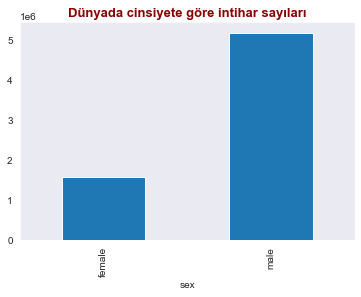

In [1194]:
df.groupby("sex")["suicides_no"].sum().plot(kind="bar")
#sns.barplot(df["sex"].sort_values(), df["suicides_no"])
plt.title("Dünyada cinsiyete göre intihar sayıları", fontdict = baslik_font)
plt.show()

In [1245]:
dfByAges = df.groupby(["age", "sex"])["suicides_no"].sum().reset_index()
dfByAges


,age,sex,suicides_no
0,05-14 years,female,16997
1,05-14 years,male,35267
2,15-24 years,female,175437
3,15-24 years,male,633105
4,25-34 years,female,208823
5,25-34 years,male,915089
6,35-54 years,female,506233
7,35-54 years,male,1945908
8,55-74 years,female,430036
9,55-74 years,male,1228407


In [1252]:
#color_gender = ['#F781D8', '#819FF7']
#plt.figure(figsize=(18,5))
#sns.barplot(dfByAges["age"].sort_values(), dfByAges["suicides_no"],hue=dfByAges["sex"])
#plt.title("Dünyada cinsiyete ve yaş grubuna göre intiharlar", fontdict = baslik_font)
#plt.show()

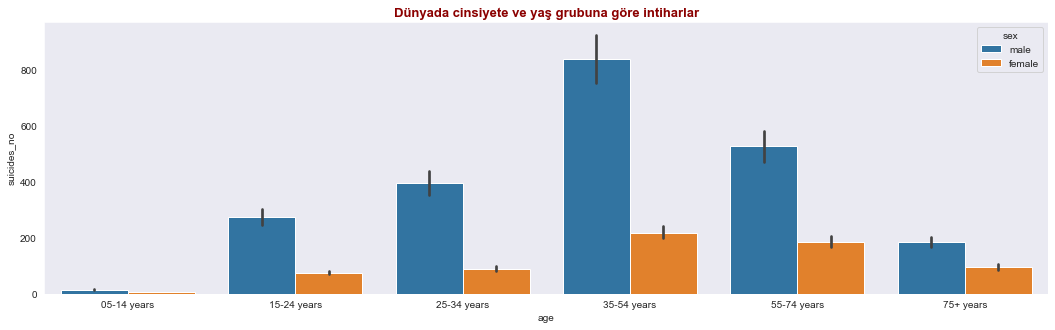

In [1195]:
#Tüm dünya genelinde tüm yaş gruplarında erkeklerin intihar sayısının fazla olduğu görülüyor.
plt.figure(figsize=(18,5))
sns.barplot(df["age"].sort_values(), df["suicides_no"],hue=df["sex"])
plt.title("Dünyada cinsiyete ve yaş grubuna göre intiharlar", fontdict = baslik_font)
plt.show()

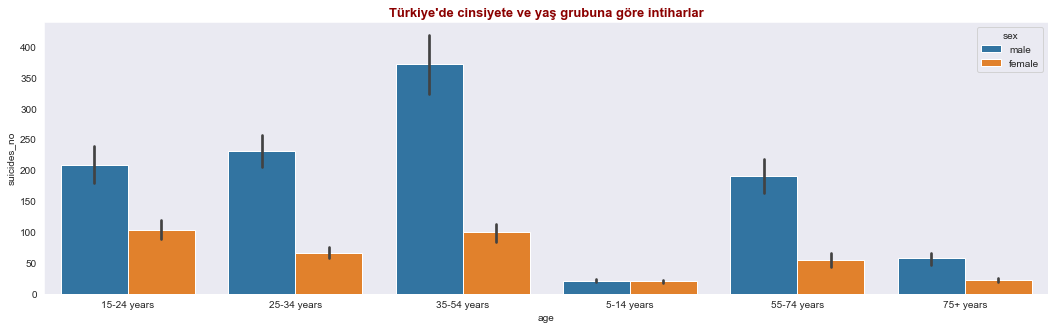

In [1196]:
#Türkiye genelinde (5-14) yaş grubu hariç tüm gruplarda erkeklerin intihar sayısının fazla olduğu görülüyor.
plt.figure(figsize=(18,5))
sns.barplot(df_turkey["age"].sort_values(), df_turkey["suicides_no"],hue=df["sex"])
plt.title("Türkiye'de cinsiyete ve yaş grubuna göre intiharlar", fontdict = baslik_font)
plt.show()

Tüm dünya genelinde erkeklerin intiharı kadınlara göre çok daha fazladır.
Aşağıdaki çizgi grafikten de kadınlarda 2014 e kadar intiharların daha durağan erkeklerde daha dalgalı olduğunu söyleyebiliriz.

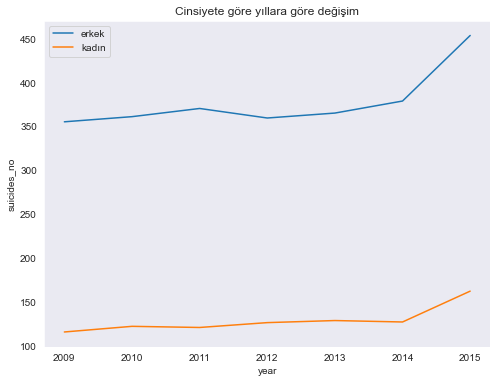

In [1197]:
plt.figure(figsize=(8,6))
erkek = df_gelyuksek[df.sex == "male"]
kadın = df_gelyuksek[df.sex == "female"]
sns.lineplot(erkek.year, df.suicides_no, ci = None)
sns.lineplot(kadın.year, df.suicides_no, ci = None)
plt.legend(["erkek", 'kadın'])
plt.title("Cinsiyete göre yıllara göre değişim")
plt.show()

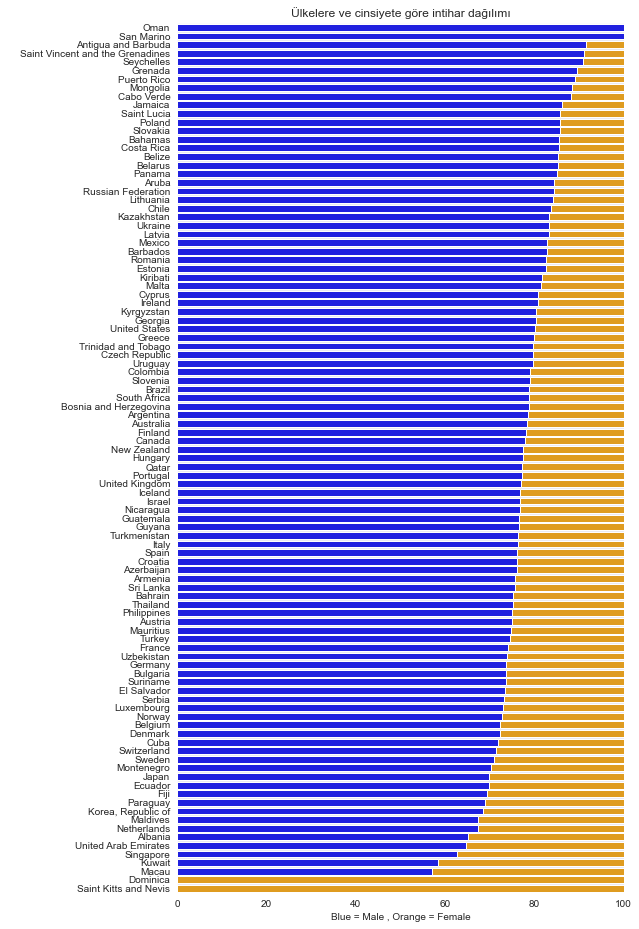

In [1225]:
count_sex_pop = df.groupby(["sex", "country"])["population"].sum()
count_sex_raw = df.groupby(["sex", "country"])["suicides_no"].sum()

count_sex_rate = ((count_sex_raw / count_sex_pop) * 100000).to_frame().reset_index()
count_sex_rate = count_sex_rate.rename(columns = {0: "rate"})
count_sex_rate = count_sex_rate.pivot(index = "country", columns = "sex", values = "rate")
count_sex_rate["male"] = (count_sex_rate["male"] / (count_sex_rate["male"] + count_sex_rate["female"])) * 100
count_sex_rate["female"] = 100
count_sex_rate.sort_values(by = "male", inplace = True, ascending = False)

plt.figure(figsize = (8, 16))

g = sns.barplot(data = count_sex_rate, x = "female", y = count_sex_rate.index, color = "orange")
sns.barplot(data = count_sex_rate, x = "male", y = count_sex_rate.index, color = "blue")
g.set_title("Ülkelere ve cinsiyete göre intihar dağılımı")
g.set_xlabel("Blue = Male , Orange = Female")
g.set_ylabel(" ")
g.set_xlim(0,100)

plt.show()

İntihar oranı en yüksek ilk 10 ülkenin cinsiyete göre intihar oranlarına bakalım.
Burada intihar sayısı olarak değil ülkenin populasyonlarına göre en yüksek olan intihar oranı üzerinden bakacağız.

In [1199]:
df_year = df.groupby(by=["country"])["suicides_no", "population"].sum()
df_year_country = df_year.copy().reset_index()
df_year_country["suicides_rate"] = df_year_country.suicides_no*100/df_year_country.population
ulkeler10=df_year_country.sort_values(by="suicides_rate",ascending=False).head(10)
ulkeler10

,country,suicides_no,population,suicides_rate
53,Lithuania,28039,68085210,0.041182
75,Russian Federation,1209742,3690802620,0.032777
87,Sri Lanka,55641,182525626,0.030484
11,Belarus,59892,197372292,0.030345
40,Hungary,73891,248644256,0.029718
52,Latvia,12770,44852640,0.028471
47,Kazakhstan,101546,377513869,0.026899
84,Slovenia,10615,40268619,0.026360
30,Estonia,7034,27090810,0.025965
95,Ukraine,319950,1286469184,0.024870


Text(0, 0.5, 'İntihar Oranı')

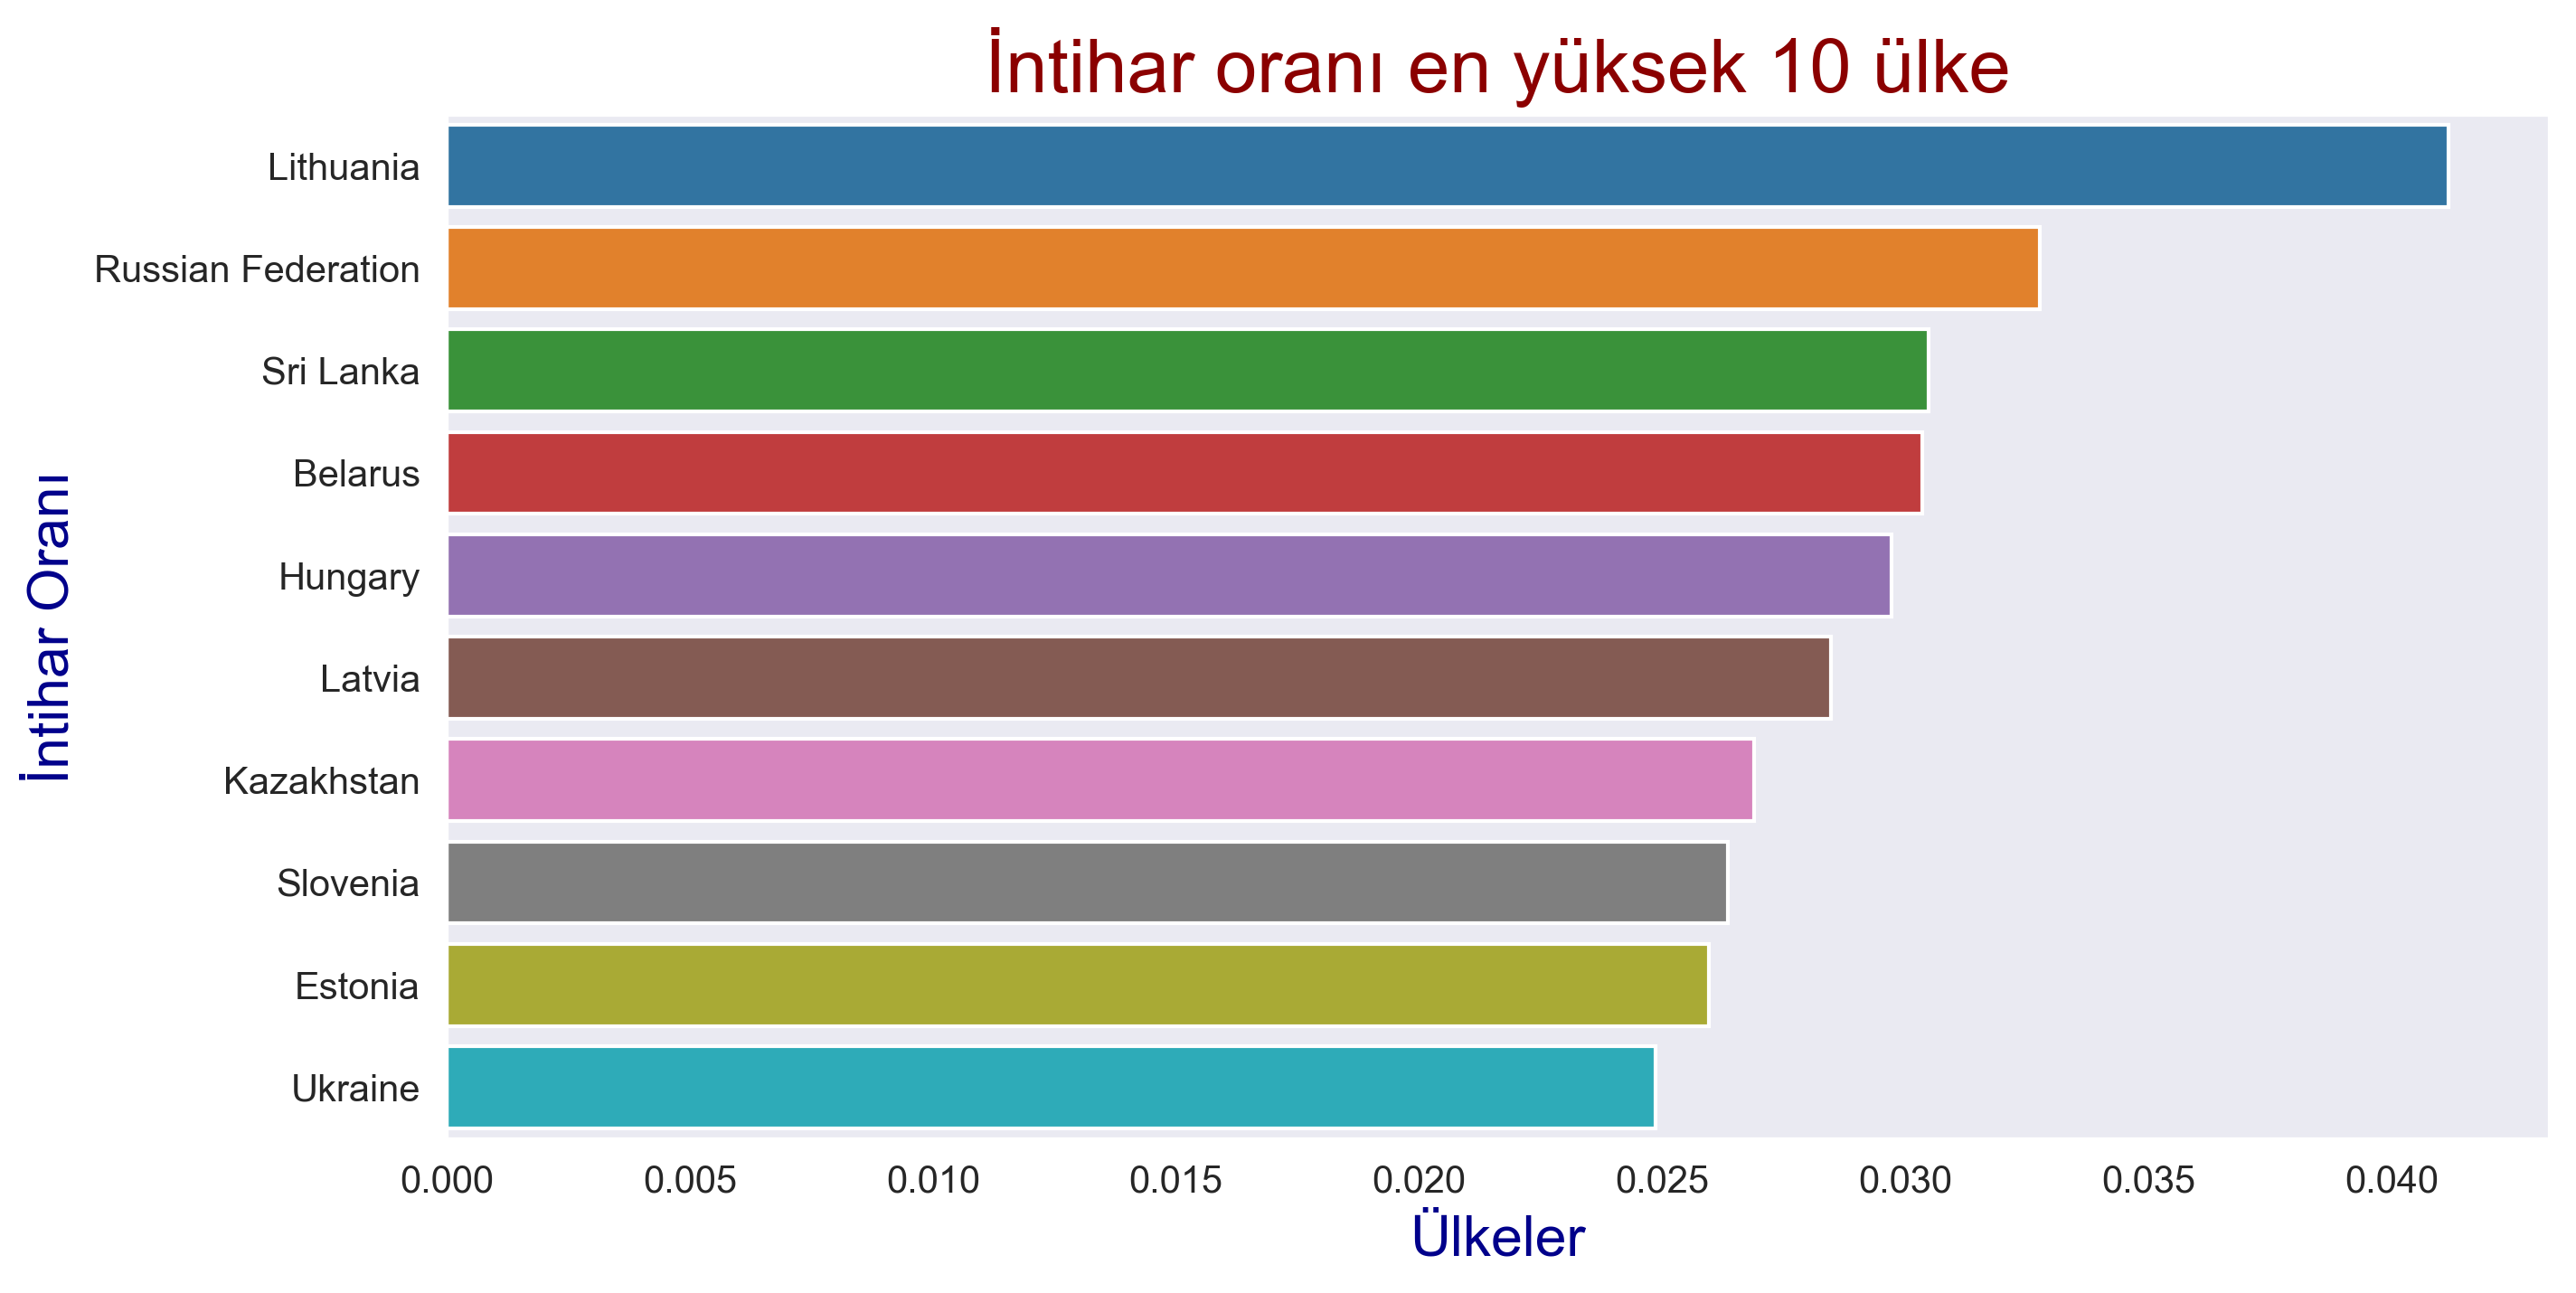

In [1200]:
#İntihar oranı en yüksek 10 ülke
plt.figure(figsize=(10,5),dpi=300)

sns.barplot(data = ulkeler10, y = "country", x = ulkeler10["suicides_rate"] , dodge = False)
plt.title("İntihar oranı en yüksek 10 ülke", fontdict = title_style)
plt.xlabel('Ülkeler', fontdict = axis_style)
plt.ylabel('İntihar Oranı', fontdict = axis_style)

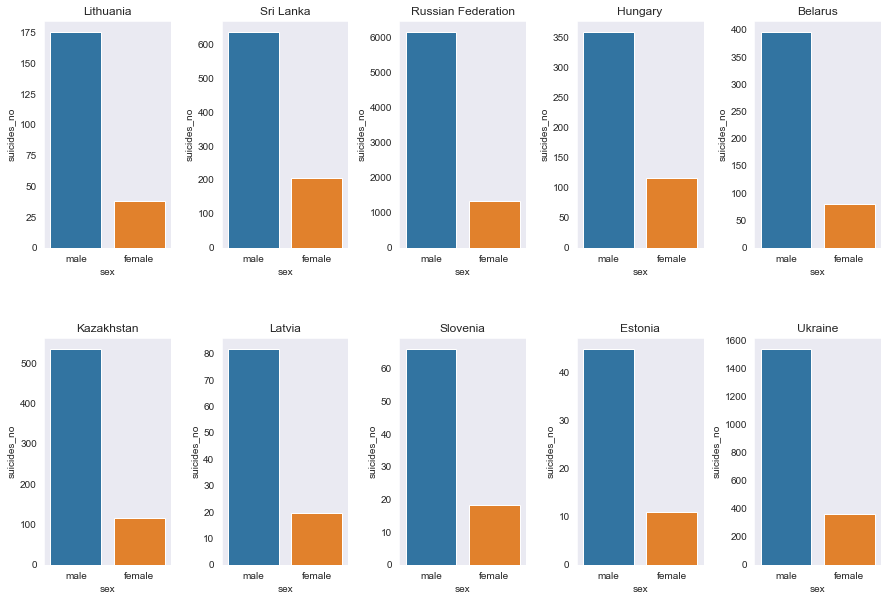

In [1201]:
#İntihar oranı en yüksek 10 ülkenin cinsiyet dağılımı

df_sumByCountry = data.groupby(["country"]).agg({'suicides/100k pop': 'mean', 'suicides_no' : 'mean', 'population' : "mean"}).sort_values(by=['suicides/100k pop'],  ascending=False).reset_index()
#df_sumByCountry
countries = np.array(df_sumByCountry["country"].head(10))

df_sumByCountry = data.groupby(["country","sex"]).agg({'suicides/100k pop': 'mean', 'suicides_no' : 'mean', 'population' : "mean"}).sort_values(by=['suicides/100k pop'],  ascending=False).reset_index()

fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(0, 10):
    ax = fig.add_subplot(2, 5, i+1)
    sns.barplot(x="sex", y="suicides_no", data=df_sumByCountry[df_sumByCountry.country == countries[i]])
    plt.title(countries[i])

Erkeklerin hepsinde çok fazla olduğu görülüyor. 

Şimdi yaş gruplarının intihar sayılarına ve oranlarına bakalım.(kategorik değişken ve sürekli değişken)

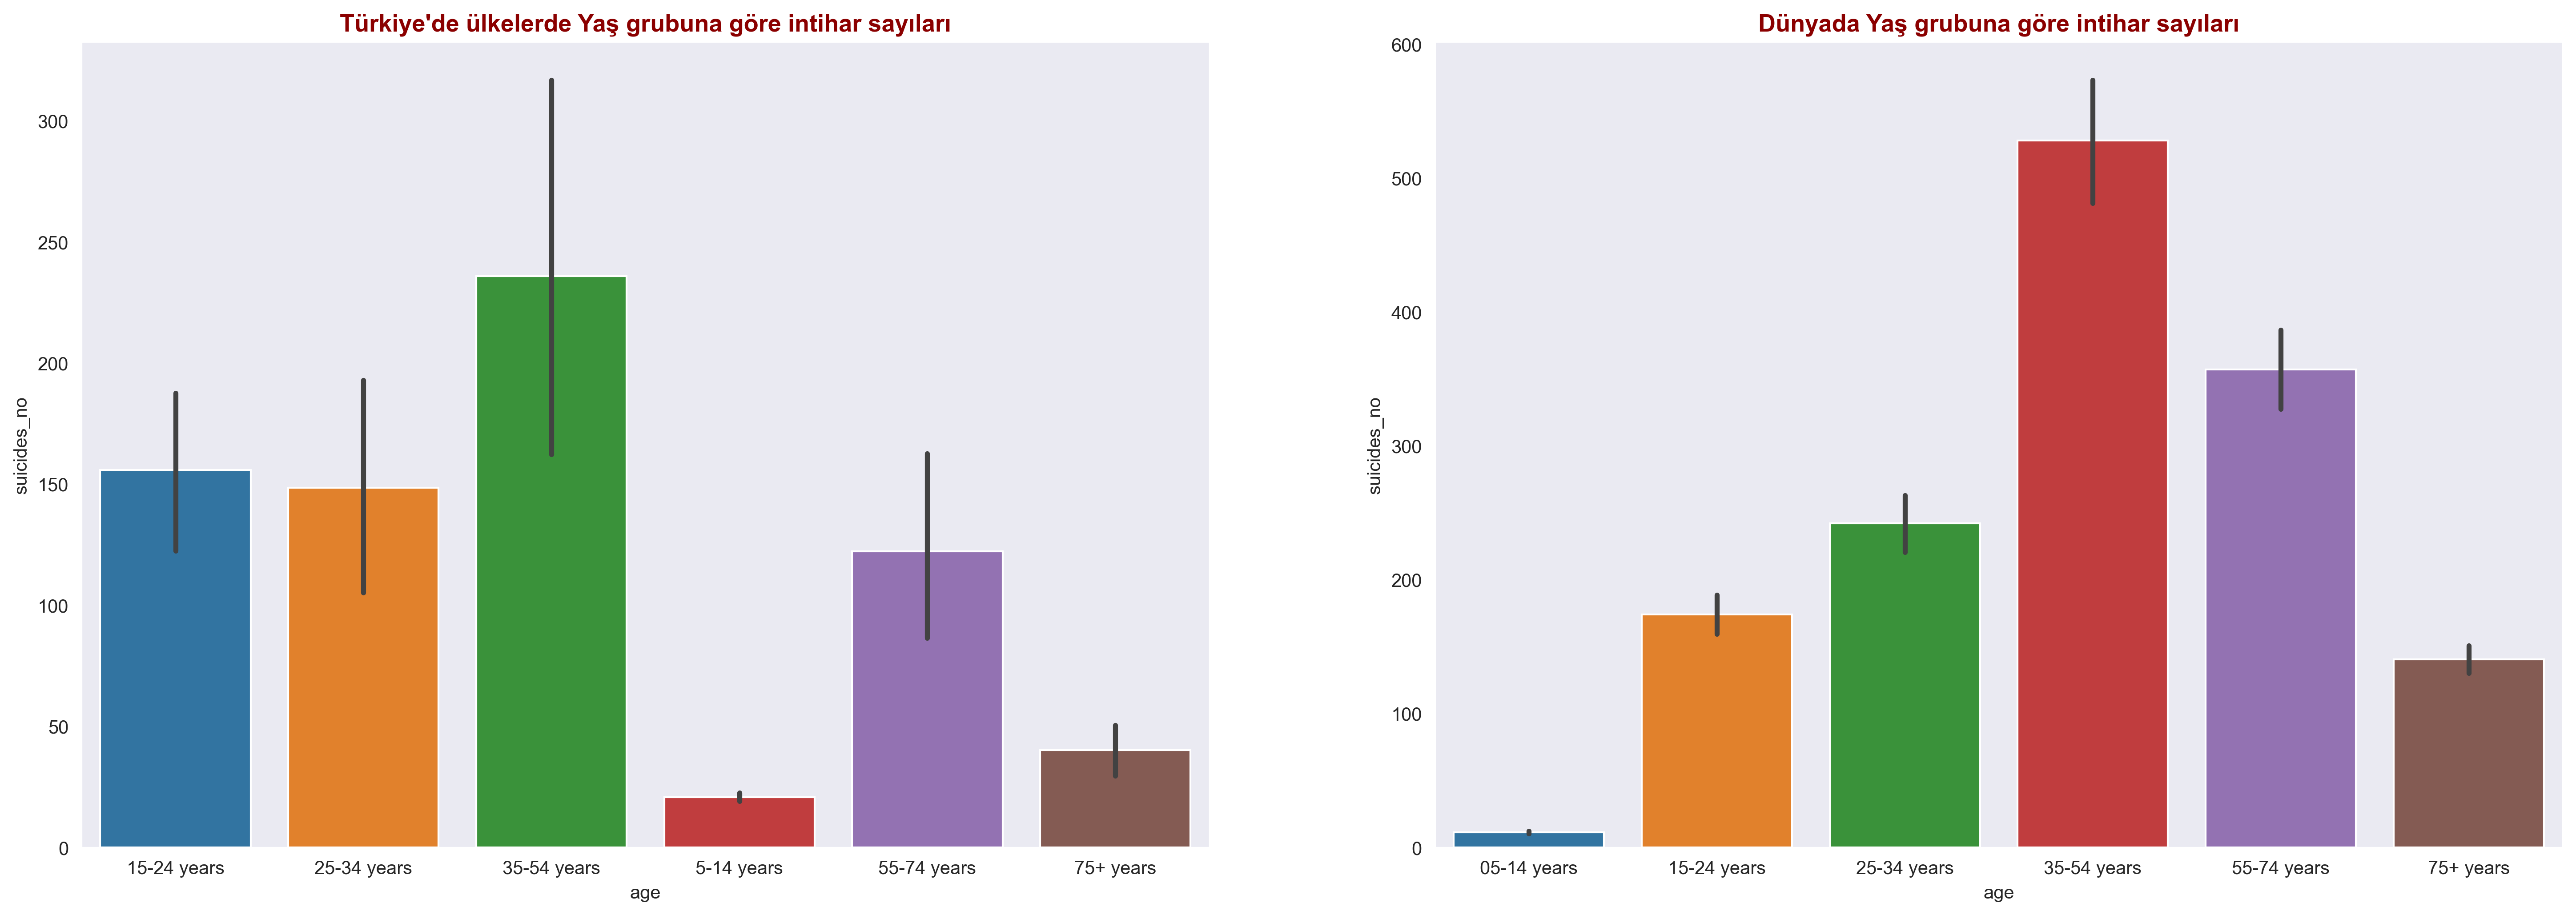

In [1256]:
plt.figure(figsize=(24,8),dpi=300)

plt.subplot(1,2,1)
sns.barplot(df_turkey["age"].sort_values(), df_turkey["suicides_no"])
plt.title("Türkiye'de ülkelerde Yaş grubuna göre intihar sayıları", fontdict = baslik_font)

plt.subplot(1,2,2)
sns.barplot(df["age"].sort_values(), df["suicides_no"])
plt.title("Dünyada Yaş grubuna göre intihar sayıları", fontdict = baslik_font)

plt.show()

35-54 yaş aralığındaki kişilerin intihar sayısı fazladır diyebiliriz. Ancak burada tabi o yaş aralığının populasyonunda fazla olduğunu düşünerek oran olarak da aşağıda bakalım.

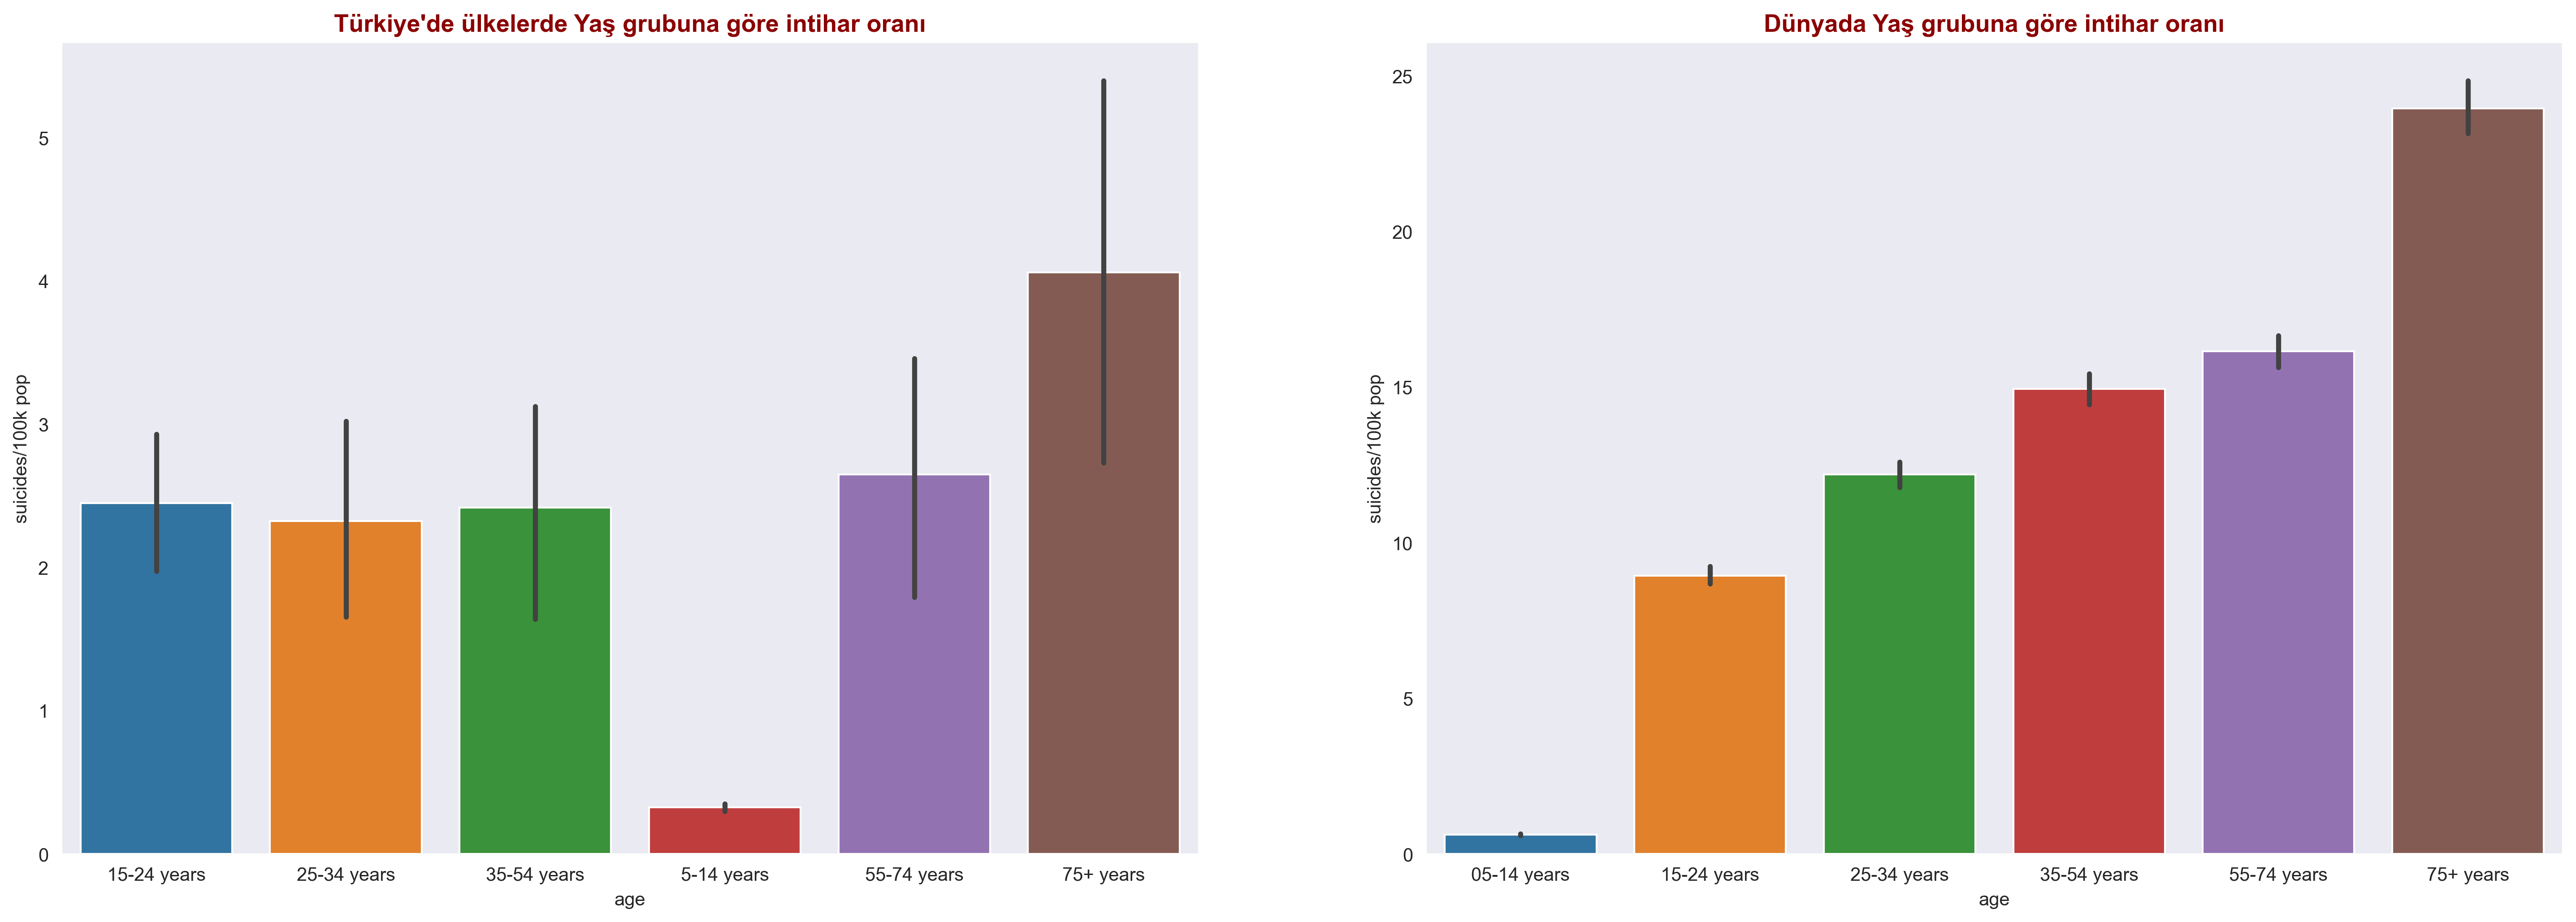

In [1254]:
plt.figure(figsize=(24,8),dpi=300)

plt.subplot(1,2,1)
sns.barplot(df_turkey["age"].sort_values(), df_turkey["suicides/100k pop"])
plt.title("Türkiye'de ülkelerde Yaş grubuna göre intihar oranı", fontdict = baslik_font)

plt.subplot(1,2,2)
sns.barplot(df["age"].sort_values(), df["suicides/100k pop"])
plt.title("Dünyada Yaş grubuna göre intihar oranı", fontdict = baslik_font)

plt.show()

#df_age = df_turkey.groupby(["age"])["suicides_no", "population"].sum()
#df_reset = df_age.copy().reset_index()
#plt.figure(figsize=(12,4))
#sns.barplot("age", df_reset.suicides_no*100/df_reset.population,data = df_reset)
#plt.show()

Tüm dünyada en fazla intihar oranının +75 yaştaki grupta olduğu görülüyor.
Belki burada yalnızlık eşlerini kaybetme hayatlarının bittiğine dair düşüncelerden dolayı intihar etme oranının yüksek olduğunu düşünebiliriz.

Dünyada yaş grubuna göre hemen hemen bir artış varken Türkiye de öyle değil.
Türkiye'de 5-14 yaş ve +75 yaş grupları haricinde ortalama benzer bir intihar oranı var.

Tüm yaş gruplarının yıllara göre intihar oranının dağılımına bakalım.

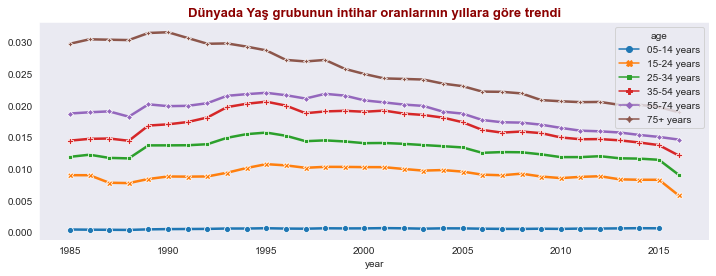

In [1227]:
df_age = df.groupby(["year","age"])["suicides_no", "population"].sum()
df_reset = df_age.copy().reset_index()
plt.figure(figsize=(12,4))
sns.lineplot("year", df_reset.suicides_no*100/df_reset.population, hue = "age",
             data = df_reset,linewidth = 2.5, style = "age", markers=True
            , dashes=False)
plt.title("Dünyada Yaş grubunun intihar oranlarının yıllara göre trendi", fontdict = baslik_font)
plt.show()

+75 yaşı azalışa geçtiği görülür. 2000 yılından sonra intiharlarda bir düşüş var.
1995 de 5-14 ve +75 yaş hariç tüm yaş gruplarında zirve yaptığı görülür.

In [1205]:
yas_yıl = pd.pivot_table(df, values ='suicides/100k pop',index=['year'],columns=['age'])
yas_yıl.head()

age,05-14 years,15-24 years,25-34 years,35-54 years,55-74 years,75+ years
year,,,,,,
1985,0.537083,8.429688,10.008750,12.403021,15.094375,24.484271
1986,0.421458,8.152083,10.593854,11.695417,13.965000,23.712187
1987,0.484815,7.487870,10.960370,12.383611,14.945833,23.602778
1988,0.477449,8.750918,12.410102,13.176020,15.843061,25.598878
1989,0.553462,9.160481,12.178173,13.584519,16.000385,25.797404


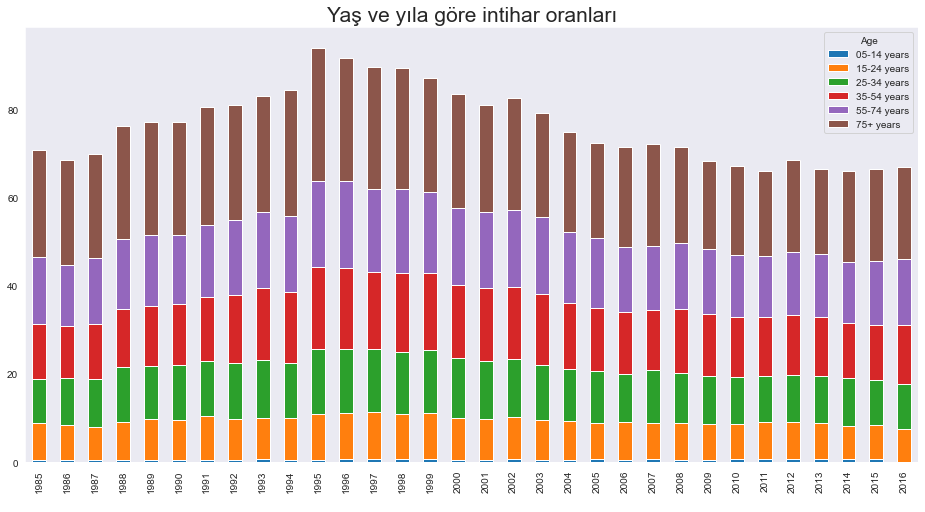

In [1206]:
yas_yıl.plot.bar(stacked=True,figsize=(16,8))
plt.legend(title='Age')
plt.xlabel(' ')
plt.title('Yaş ve yıla göre intihar oranları',fontsize=21);

Jenerasyona göre intihar oranlarına bakalım.(kategorik değişken ile sürekli değişken)

Text(0.5, 1.0, 'Dünyada jenerasyona göre intihar oranları')

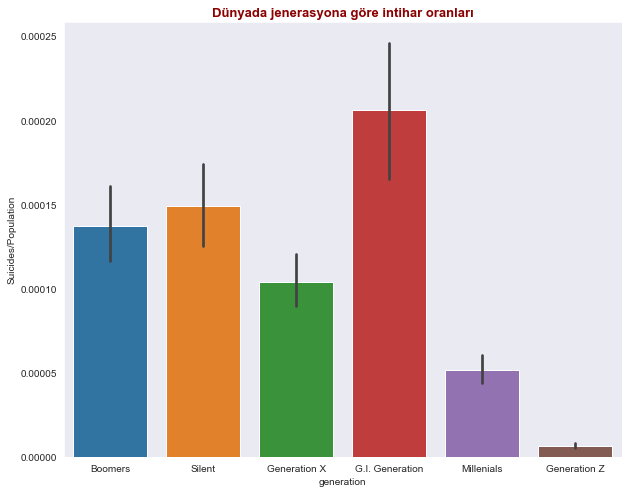

In [1228]:
df_countries_gen = df.groupby(["country","generation"]).agg({'gdp_per_capita ($)': 'mean', 'suicides_no' : 'mean', 'population' : "mean"}).sort_values(by=['suicides_no'],  ascending=False).reset_index()
df_countries_gen["Suicides/Population"] = df_countries_gen.suicides_no/df_countries_gen.population
fig = plt.figure(figsize=(10,8))
sns.barplot(x="generation", y="Suicides/Population", data= df_countries_gen)
plt.title("Dünyada jenerasyona göre intihar oranları", fontdict = baslik_font)

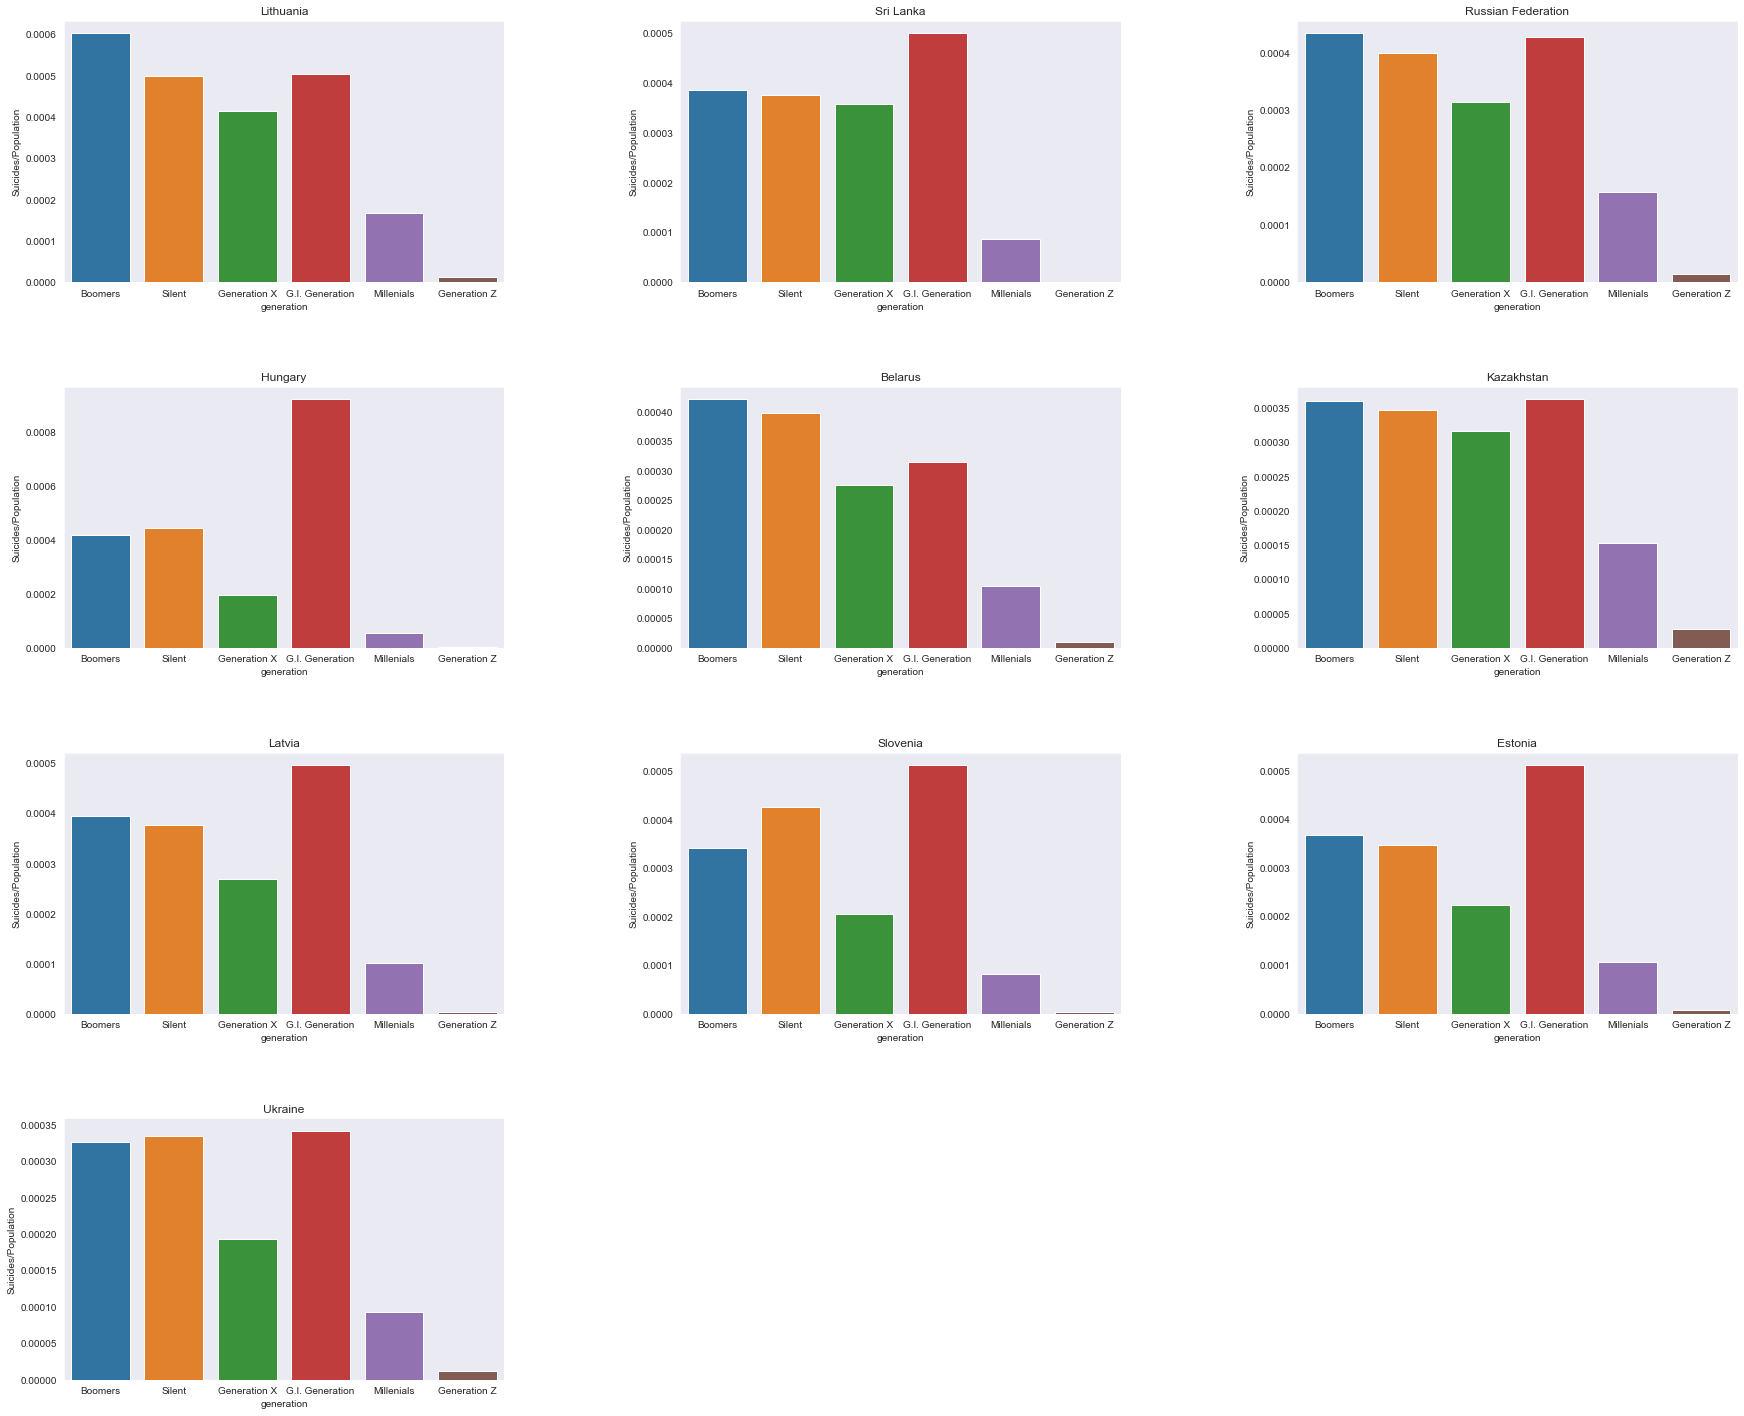

In [1208]:
#En yüksek 10 ülkede jenerasyonlara göre bakalım.

fig = plt.figure(figsize=(30,25))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
generations = df_countries_gen["generation"].unique()
for i in range(10):
    ax = fig.add_subplot(4, 3, i+1)
    sns.barplot(x="generation", y="Suicides/Population", data= df_countries_gen[ df_countries_gen.country == countries[i]], order=generations)
    plt.title(countries[i])

Burada cinsiyet dağılımında ki gibi değil biraz işler değişmiş. Bazı ülkelerde bazı jenerasyonların çok daha fazla ve az olduğu görülüyor. Bu da belki o ülkedeki savaşlar,nesiller arası aktarım vs ile yorumlanabilir.

Jenarasyonların yıl içinde değişimine bakalım.

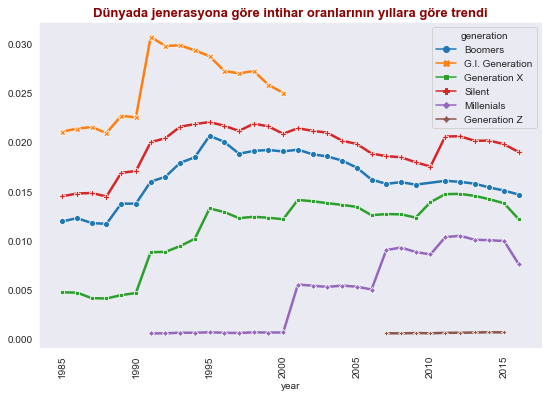

In [1229]:
df_generation = df.groupby(["year", "generation"])["suicides_no", "population"].sum()
df_generation_reset = df_generation.copy().reset_index()
plt.figure(figsize=(9,6))
sns.lineplot("year", df_generation_reset.suicides_no*100/df_generation_reset.population, hue = "generation", 
            data = df_generation_reset, linewidth = 2.5, style = "generation", markers=True
            , dashes=False)
plt.xticks(rotation = 90)
plt.title("Dünyada jenerasyona göre intihar oranlarının yıllara göre trendi", fontdict = baslik_font)
plt.show()

Türkiyenin ve dünyanın intihar oranını yıllar bazında kıyaslayalım.

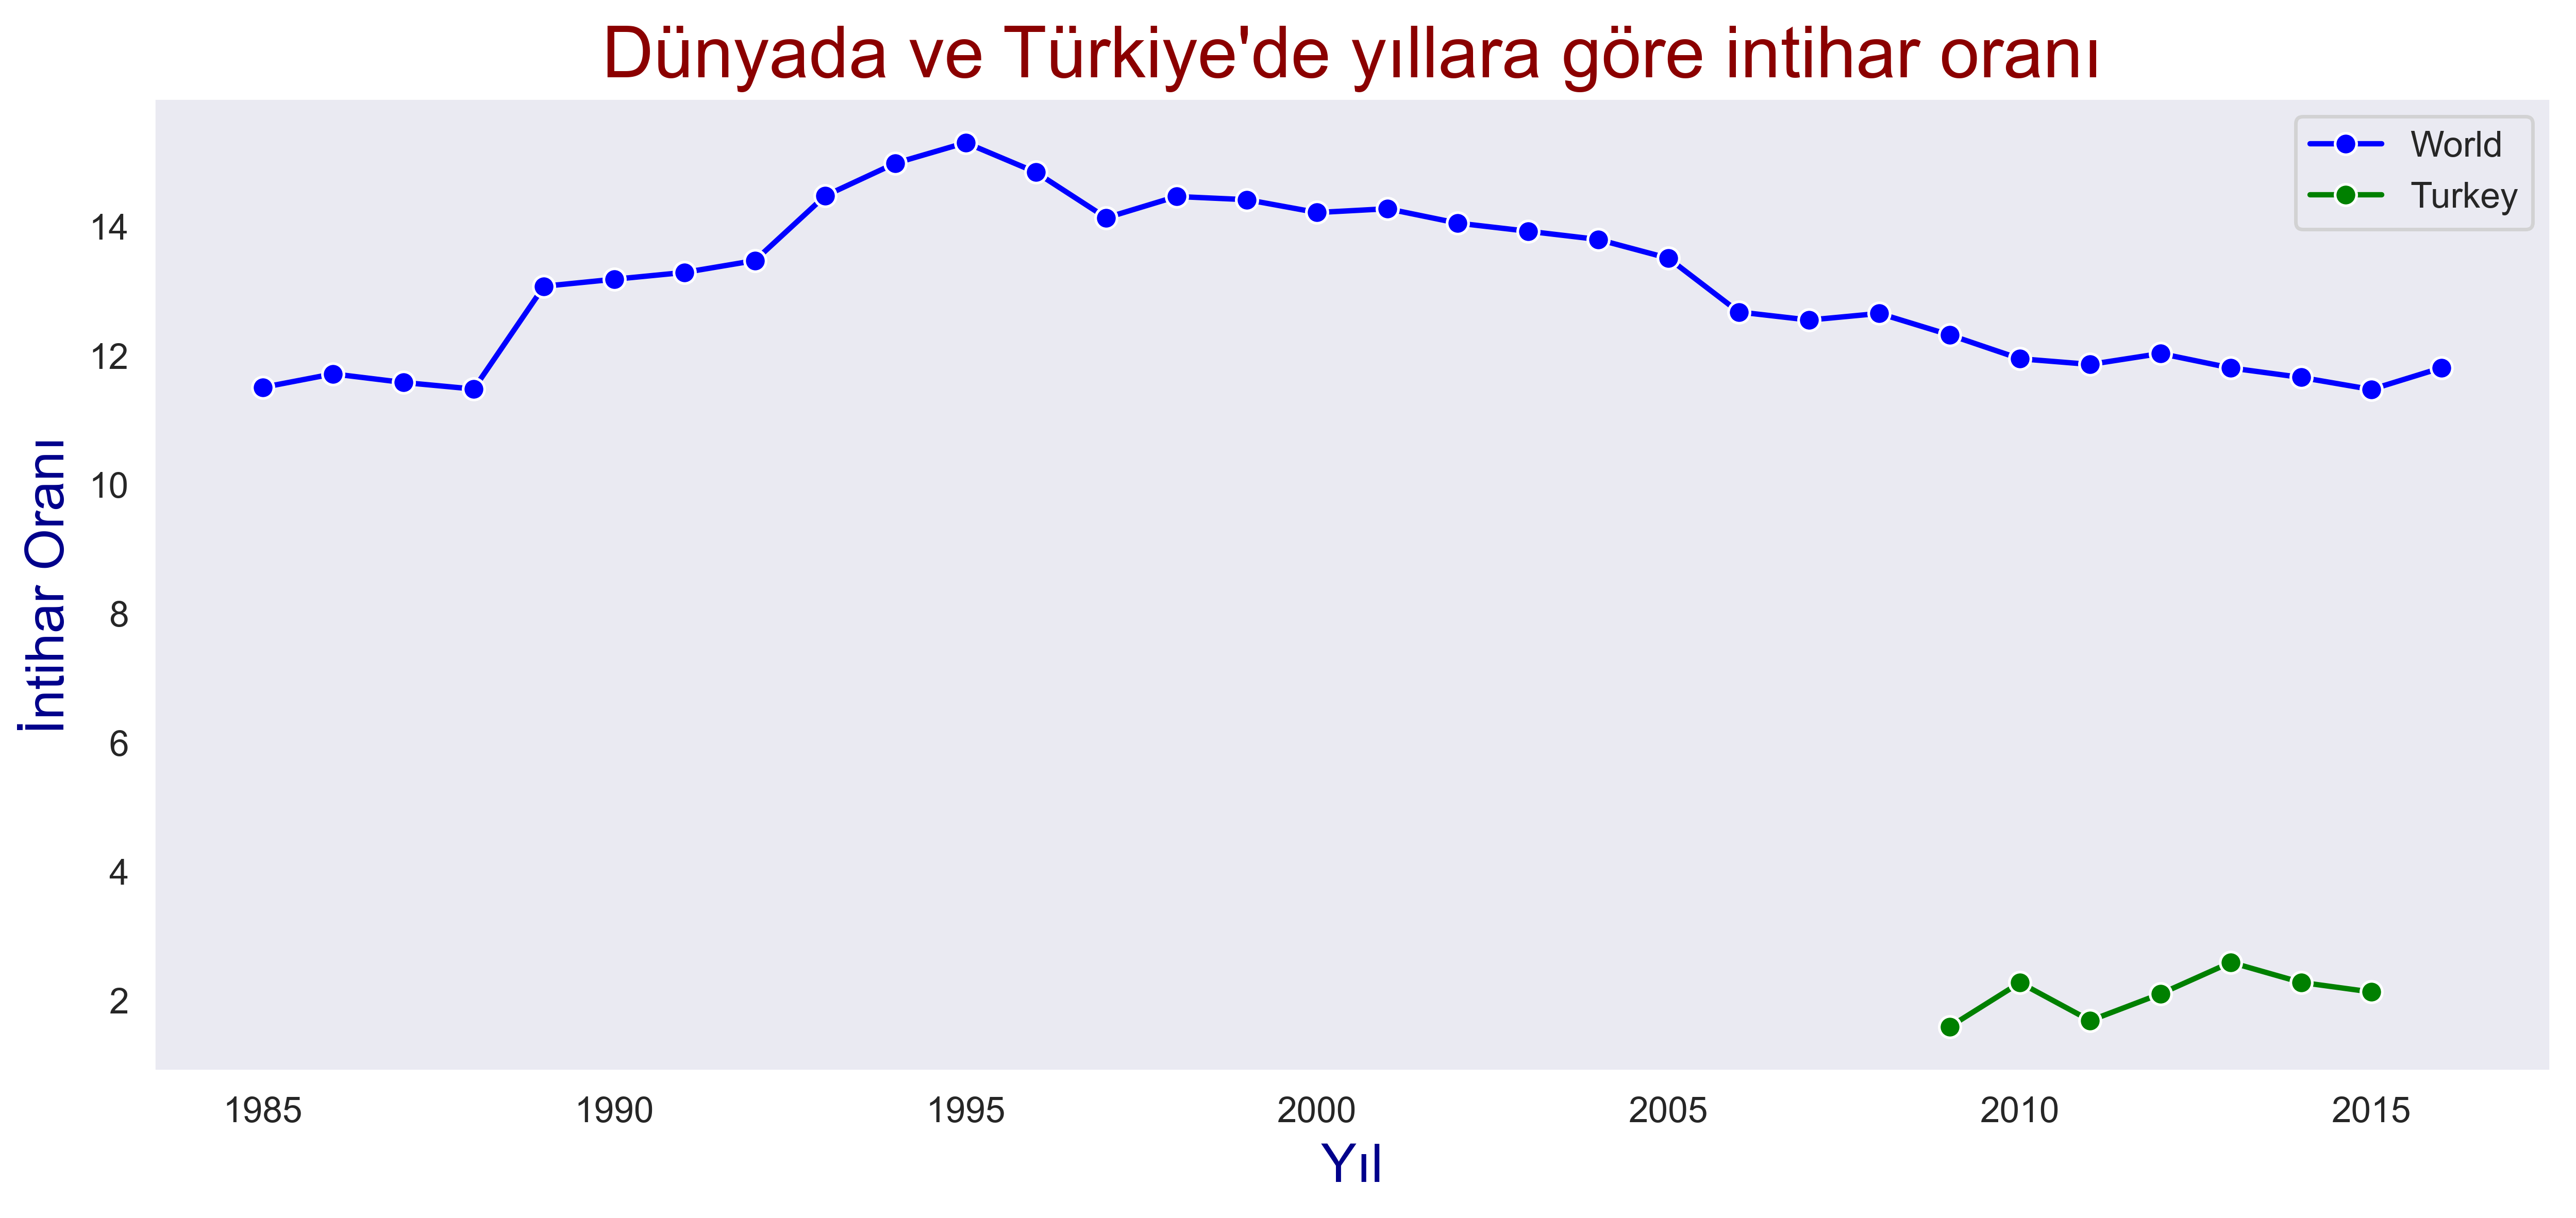

In [1210]:
plt.figure(figsize=(12, 5), dpi = 500)

yearly_pop = df.groupby("year")["population"].sum()
yearly_raw = df.groupby("year")["suicides_no"].sum()
yearly_rate = yearly_raw / yearly_pop * 100000

yearly_pop_tr = df_turkey.groupby("year")["population"].sum()
yearly_raw_tr = df_turkey.groupby("year")["suicides_no"].sum()
yearly_rate_turkey = yearly_raw_tr/ yearly_pop_tr * 100000

sns.lineplot(data =yearly_rate,  label='World', color='blue',err_style = None,marker = "o")
sns.lineplot(data =yearly_rate_turkey,  label='Turkey', color='green',err_style = None,marker = "o")


#sns.lineplot(x=df["year"],y='suicides/100k pop', data =df,  label='World', color='blue',err_style = None)
#sns.lineplot(x=df["year"], y = 'suicides/100k pop', data =df_turkey, label='Turkey', color='green',err_style = None)

plt.title("Dünyada ve Türkiye'de yıllara göre intihar oranı", fontdict = title_style)
plt.xlabel('Yıl', fontdict = axis_style)
plt.ylabel('İntihar Oranı', fontdict = axis_style)
plt.show()


Yukarıdaki grafikten ;
Dünya genelinde göre intihar oranının azalışa geçtiği görülür.
Türkiye 'de yıllara göre çok dalgalanma vardır. Türkiye 'de dünyanın aksine 2010,2013 yıllarında peak yaptığı görülür.

Sürekli değişkenlerden intihar oranı ile kişi başı gelir arasında ilişki var mı ona bakalım.(İkisi de sürekli değişken)

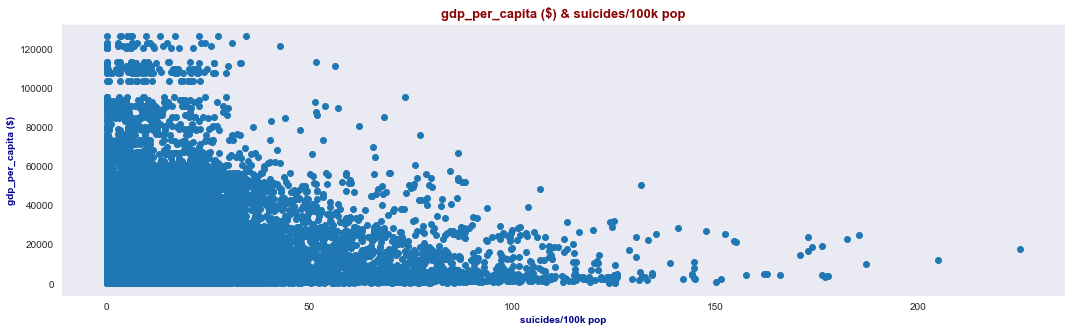

In [1211]:
plt.figure(figsize=(18,5))
plt.scatter(df["suicides/100k pop"], df["gdp_per_capita ($)"])
plt.title("gdp_per_capita ($) & suicides/100k pop", fontdict=baslik_font)
plt.xlabel('suicides/100k pop', fontdict=eksen_font )
plt.ylabel('gdp_per_capita ($)', fontdict=eksen_font )


plt.show()

Çok anlamlı bir ilişki göremedim. Resmi olarak bakmak için korelasyon katsayısına bakalım.

In [1212]:
#df.drop("year",axis=1).corr()
df[["suicides/100k pop","gdp_per_capita ($)"]].corr()

,suicides/100k pop,gdp_per_capita ($)
suicides/100k pop,1.000000,0.001785
gdp_per_capita ($),0.001785,1.000000


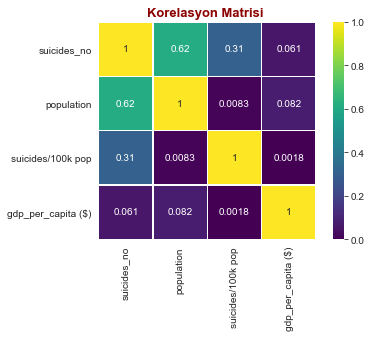

In [1213]:
sns.heatmap(df.drop("year",axis=1).corr(), square=True, annot=True, linewidths=.5, vmin=0, vmax=1, cmap='viridis')
plt.title("Korelasyon Matrisi ", fontdict=baslik_font)

plt.show()

Birbirleriyle negatif ya da pozitif bir ilişki yoktur.

Ancak bunu genel için baktık. Belki bazı ülkeler için böyle bir korelasyon olabilir.

In [1214]:
ulke = df["country"].unique()
county_num= df["country"].nunique()
colors = np.random.rand(93)

df_suino = df.groupby(["country","year"])["suicides_no"].sum()
df_sum = df_suino.sort_index(ascending=True)[:] * 100

df_pop = df.groupby(["country","year"]).population.sum()
df_pop_sum = df_pop.sort_index(ascending=False)[:]

df_total = df_sum / df_pop_sum
df_total.head(10)

#df_age1 = df.groupby(["country","year"])["suicides_no", "population"].sum()
#df_reset1 = df_age1.copy().reset_index()
#df_reset1["suı/pop"]=df_reset1.suicides_no*100/df_reset1.population
#df_total=df_reset1
#df_total

country  year
Albania  1987    0.002694
         1988    0.002279
         1989    0.002426
         1992    0.001665
         1993    0.002600
         1994    0.001755
         1995    0.003031
         1996    0.003027
         1997    0.005710
         1998    0.005112
dtype: float64

In [1215]:
country_dict={}
for country in df_total.index.get_level_values(0):
    if country not in country_dict.keys():
        country_dict[country] = df_total[country].mean()
    else:
        pass

tup = list(country_dict.items())
tup.sort(key= lambda pair:pair[1], reverse = True)

country_list = [a[0] for a in tup]
country_suicide = [a[1] for a in tup]

In [1216]:
df_gdp = df.groupby(["country","year"])["gdp_per_capita ($)"].mean()

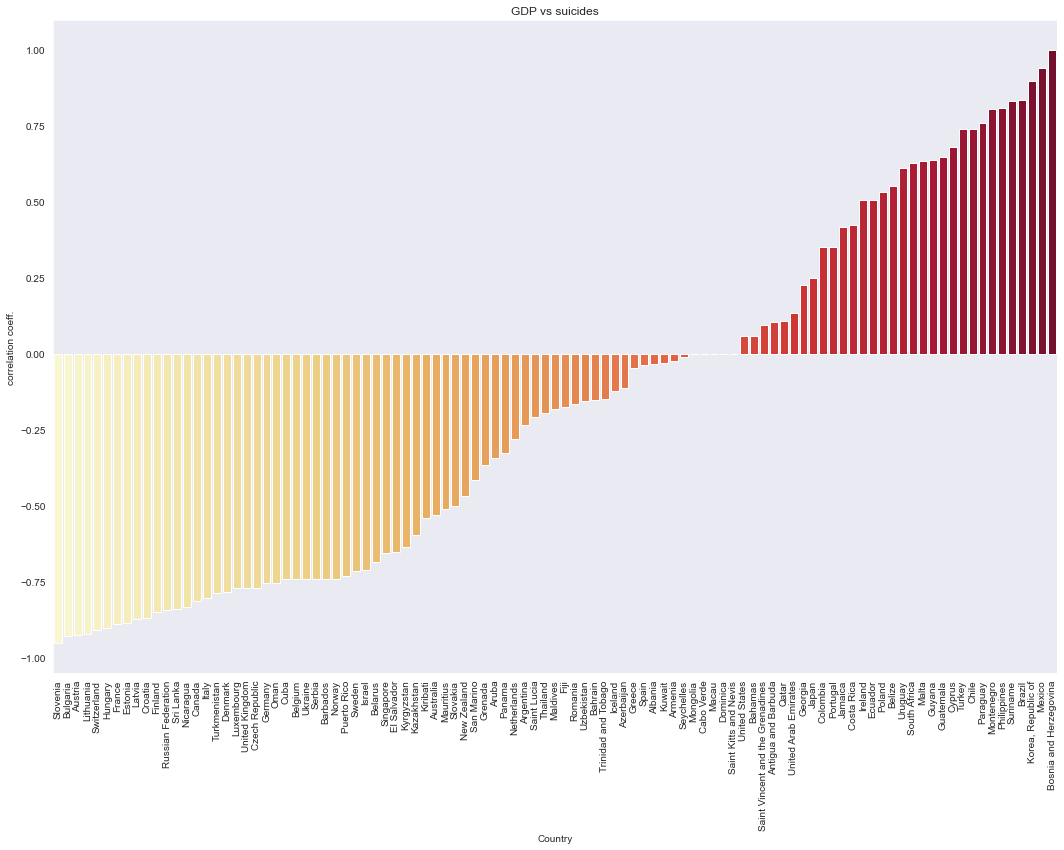

In [1217]:
corr_eff = {}
p_value_eff = {}
for country in country_list[:]:
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_gdp[country].values, df_total[country].values)
    corr_eff[country] = float(r_value)
    p_value_eff[country] = float(p_value)

gdp_tup = list(corr_eff.items())
gdp_tup.sort(key= lambda pair:pair[1], reverse = False)
dgp_relation = {a[0]:a[1] for a in gdp_tup}

plt.figure(figsize=(18,12))
sns.barplot(x=list(dgp_relation.keys()), y=list(dgp_relation.values()), palette = "YlOrRd")
plt.xticks(rotation = 90)
plt.xlabel("Country")
plt.ylabel("correlation coeff.")
plt.title("GDP vs suicides")
plt.show()

Yukarıda bazı ülkeler için negatif ve pozitif korelasyon vardır. Korelasyon >0,7 olanlara bir bakalım.

In [1218]:
positive_relation_gdp = {a:b for a,b in corr_eff.items() if b > 0.7}
positive_relation_tup = list(positive_relation_gdp.items())
positive_relation_tup.sort(key= lambda pair:pair[1], reverse = True)
positive_relation = {a[0]:a[1] for a in positive_relation_tup}
print(len(positive_relation))
positive_relation

10


{'Bosnia and Herzegovina': 0.9999999999999999,
 'Mexico': 0.9392731898535472,
 'Korea, Republic of': 0.8967892885653613,
 'Brazil': 0.8356111067311864,
 'Suriname': 0.8333078326024657,
 'Philippines': 0.8099497394094539,
 'Montenegro': 0.8042382321252367,
 'Paraguay': 0.7599968993976424,
 'Chile': 0.7412265208253951,
 'Turkey': 0.7398789818429371}

Kişi başı milli gelir ve intihar oranının pozitif arttığı ülkelere grafikle bakalım

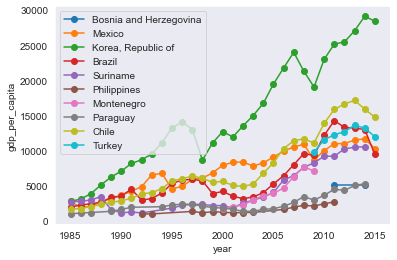

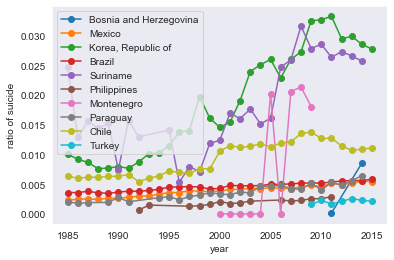

In [1219]:
city_list = list({a:b for a,b in positive_relation.items()})
for country in city_list[:10]:
    plt.plot(df_gdp[country].index,df_gdp[country].values, label=country, marker="o")
plt.xlabel("year")
plt.ylabel("gdp_per_capita")
plt.legend()
plt.show()

for country in city_list[:10]:
    plt.plot(df_total[country].index,df_total[country].values, label=country, marker="o")
plt.xlabel("year")
plt.ylabel("ratio of suicide")
plt.legend()
plt.show()

Yukarıda Örneğin Kore'de kişi başı gelir çok artarken intihar oranıda çok artmış.

Negatif olanlara bakalım. Yani kişi başı milli gelir artarken intihar oranının azaldığı ülke sayısına.
Bazı Ülkelerde de hiç bununla ilgili olmadığını görebiliriz.

In [1220]:
#Negatif olarak kolere olanların sayısı
high_relation_gdp = {a:b for a,b in dgp_relation.items() if b <= -0.6}
print(len(high_relation_gdp))

36


In [1221]:
#Hiç kolere olmayanların sayısı
without_relation_gdp = {a:b for a,b in corr_eff.items() if -0.3 < b < 0.3}
no_relation_gdp = [i for i in country_list[:20] if i in without_relation_gdp.keys()]
no_relation_gdp

['Japan', 'Mongolia']

Kategorik değerleri kukla değişkene çevireceğim. İleride makina algoritmalarında kullanabilmek için. Şimdi kullanmayacağım için farklı bir dataframede tutacağım.

In [1222]:
df2 = pd.get_dummies(df,columns=['sex','age','generation'],drop_first=True)
df2.head()

,country,year,suicides_no,population,suicides/100k pop,gdp_per_capita ($),Continent,sex_male,age_15-24 years,age_25-34 years,age_35-54 years,age_55-74 years,age_75+ years,generation_G.I. Generation,generation_Generation X,generation_Generation Z,generation_Millenials,generation_Silent
0,Albania,1987,21,312900,6.71,796,Europe,1,1,0,0,0,0,0,1,0,0,0
1,Albania,1987,16,308000,5.19,796,Europe,1,0,0,1,0,0,0,0,0,0,1
2,Albania,1987,14,289700,4.83,796,Europe,0,1,0,0,0,0,0,1,0,0,0
3,Albania,1987,1,21800,4.59,796,Europe,1,0,0,0,0,1,1,0,0,0,0
4,Albania,1987,9,274300,3.28,796,Europe,1,0,1,0,0,0,0,0,0,0,0


# Sonuç

İntihar sayıları cinsiyet değişkenine göre değişmektedir. Erkekler kadınlara göre 3-4 katı kadar fazla intihar etmektedir.

Yaş aralığı olarak baktığımızda +75 yaş grubunda intihar oranı çok daha fazladır. Bunun nedenleri de yalnızlık eşlerini
kaybetme,hayattan beklentilerinin kalmaması olabilir. Bu yaş grubuna devletlerin belki daha farklı projeler üretmesi gerekir.
Yaşlara göre dünyada baktığımızda yaş arttıkça intihar oranının arttığı açık bir şekilde gözüküyor.5-14 yaş grubundan sonra 
bir sıçrama mevcut.1995 de 5-14 ve +75 yaş hariç tüm yaş gruplarında zirve yaptığı görülür.

Yıllara göre genel baktığımızda intihar oranlarının azalış eğilimi göstermektedir. 

Jenerasyona göre; X ve Y kuşağının intihar oranı adım adım artmaktadır. Ve genel bakıldığında kuşak yaşı 20 nin üstüne çıktığında
artış gösteriyor. Gençlerin bagımsızlaştığında,aileden koptuğunda olan bir durum.

Kişi başı gelire göre baktığımızda aslında kişi başı gelir artarken intihar oranının azalmasını bekleriz. Ama bu bazı ülkeler için böyle iken bazı ülkeler için tam tersi bazıları için hiç etkilemediğini gördük.

Sonuç olarak ; intihar oranı, cinsiyet,yaş grubu,kişi başı gelir faktörlerine bağlıdır.Ayrıca jeneresyona bakarak sosyal 
baskıya da bağlıdır diyebiliriz.

